# P4. CarND-Advanced-Lane-Lines
---
CarND-Advanced-Lane-Lines is the 4th project of Udacity's self-driving car nano program, term 1. In this project, you should apply camera clibration, image undistortion, perspective transform, gradient and color thresholding, polynomial fitting and forecasting, and many other small tricks to find the left and right lane lines on a road.


## 1. Camera calibration & image undistortion
---

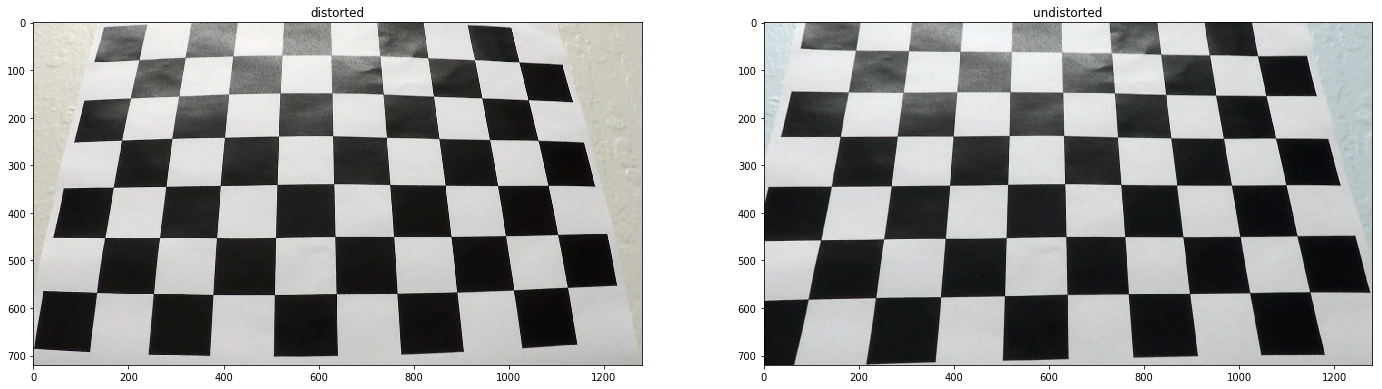

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0), ..., (8,5,0)
nx = 9
ny = 6
objp = np.zeros((nx*ny, 3), np.float32)
objp[:,:2]=np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
#images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx in range(20):
    img = cv2.imread('camera_cal/calibration'+str(idx+1)+'.jpg')
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        write_name = 'camera_cal/corners_found'+str(idx+1)+'.jpg'
        cv2.imwrite(write_name, img)

##########################################################
##cv2.destroyAllWindows()
#%matplotlib inline
#f, axes = plt.subplots(1, 2, figsize=(30,20))
#axes[0].imshow(cv2.cvtColor(cv2.imread("camera_cal/calibration"+str(3)+".jpg"), cv2.COLOR_BGR2RGB))
#axes[0].set_title('Original', fontsize=15)
#axes[1].imshow(cv2.cvtColor(cv2.imread('camera_cal/corners_found'+str(3)+'.jpg'), cv2.COLOR_BGR2RGB))
#axes[1].set_title('Found Corners', fontsize=15)

##########################################################
# A function that takes an image, object points, and image points
# performs the camera calibration, image distortion correction and 
# returns the undistorted image
def cal_undistort(img, objpoints, imgpoints):
    """
    pipeline
    """
    # grayscale the image
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Use cv2.calibrateCamera() and cv2.undistort()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

# Step through the list of test images
for i in range(6):
    img = cv2.imread("test_images/test"+str(i+1)+".jpg")
    dst = cal_undistort(img, objpoints, imgpoints)
    cv2.imwrite('test_images/test_undist'+str(i+1)+'.jpg',dst)
for i in range(2):
    img = cv2.imread("test_images/straight_lines"+str(i+1)+".jpg")
    dst = cal_undistort(img, objpoints, imgpoints)
    cv2.imwrite('test_images/straight_lines_undist'+str(i+1)+'.jpg',dst)
#img = cv2.imread("special.jpg")
#dst = cal_undistort(img, objpoints, imgpoints)
#cv2.imwrite('special_undist.jpg',dst)


##############################################################################
# Visualize undistortion
%matplotlib inline
f, axes = plt.subplots(1,2, figsize=(24,9))
img = cv2.imread("camera_cal/calibration"+str(3)+".jpg")
axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
axes[0].set_title('distorted')
undist_3 = cal_undistort(img, objpoints, imgpoints) # use 'calibration3.jpg' as an example
axes[1].imshow(undist_3)
axes[1].set_title('undistorted')


#f, axes = plt.subplots(8, 2, figsize=(30,20))
#for i in range(2):
#    axes[i, 0].imshow(cv2.cvtColor(cv2.imread("test_images/straight_lines"+str(i+1)+".jpg"), cv2.COLOR_BGR2RGB))
#    axes[i, 0].set_title('Original Image', fontsize=15)
#    axes[i, 1].imshow(cv2.cvtColor(cv2.imread('test_images/straight_lines_undist'+str(i+1)+'.jpg'), cv2.COLOR_BGR2RGB))
#    axes[i, 1].set_title('Undistorted Image', fontsize=15)
#for i in range(6):
#    axes[i+2, 0].imshow(cv2.cvtColor(cv2.imread("test_images/test"+str(i+1)+".jpg"), cv2.COLOR_BGR2RGB))
#    axes[i+2, 0].set_title('Original Image', fontsize=15)
#    axes[i+2, 1].imshow(cv2.cvtColor(cv2.imread('test_images/test_undist'+str(i+1)+'.jpg'), cv2.COLOR_BGR2RGB))
#    axes[i+2, 1].set_title('Undistorted Image', fontsize=15)


---

## 2. Pipeline (single images)
---

### 2.1 Color and gradient thresholding
---

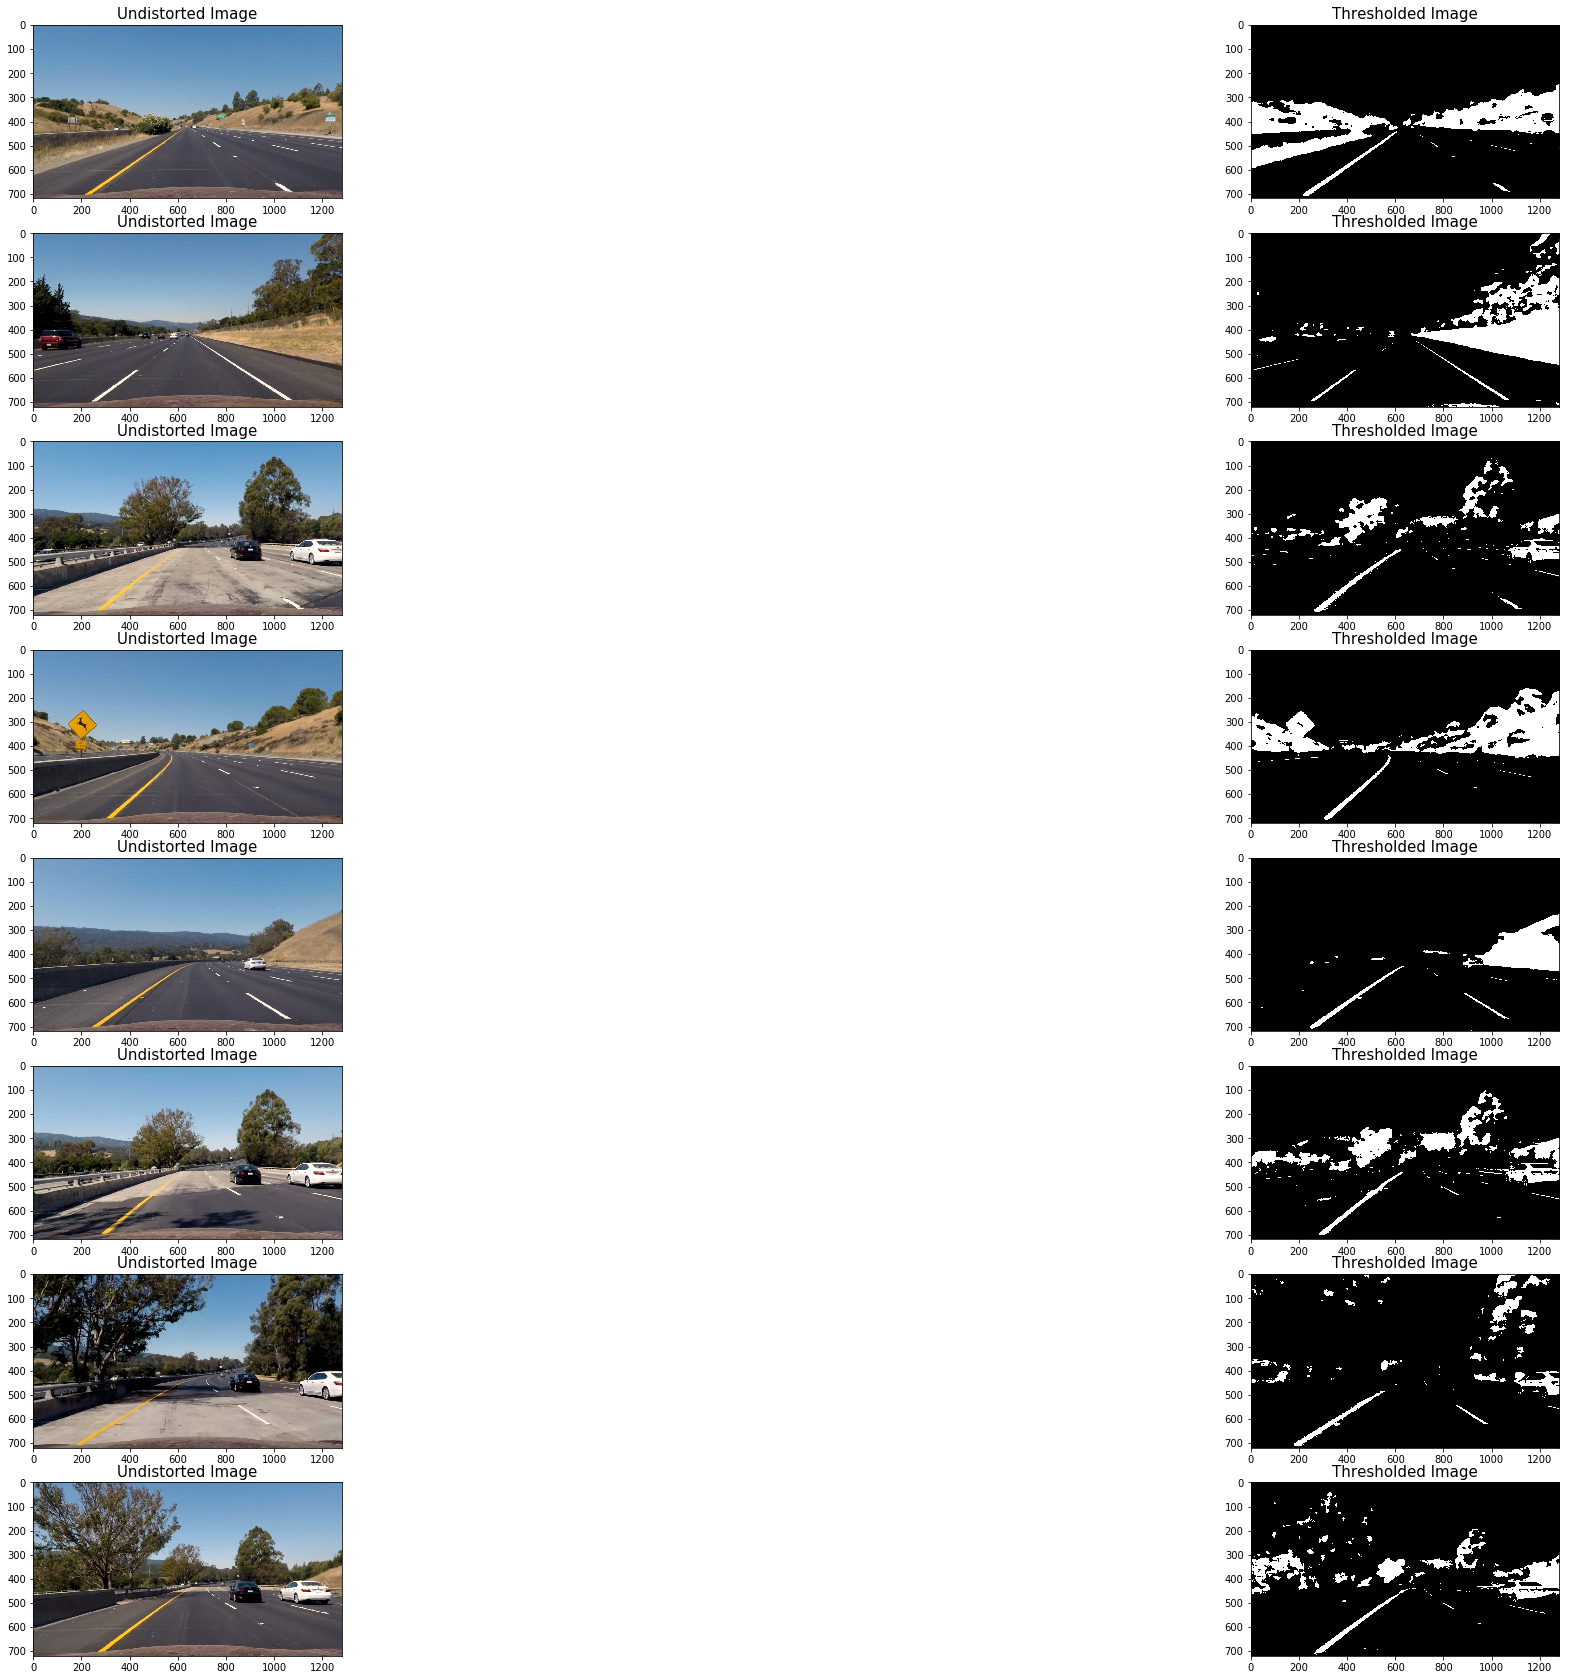

In [2]:
# Edit this function to create your own pipeline.
def color_grad_thresh(img):
    """
    pipeline
    """
    img = np.copy(img) # assumed BGR
    
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,2]
    
    # R of RGB and L of LUV for detecting WHITE lines
    r_channel = img[:,:,2]
    luv = cv2.cvtColor(img, cv2.COLOR_BGR2Luv)
    l_channel = luv[:,:,0]
    
    # b of Lab and V of HSV for detecting YELLOW lines
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    v_channel = hsv[:,:,2]
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
    b_channel = lab[:,:,2]
    #print(np.min(b_channel))
    #print(np.max(b_channel))
    
    
    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = 15) # Take the derivative in x
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = 15) # Take the derivative in y
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    sg_binary =  np.zeros_like(absgraddir)
    sg_binary[(absgraddir >= 0.7) & (absgraddir <= 1.3)] = 1
    
    # Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    # Threshold color channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    ## WHITE
    r_thresh_min = 220 # lecture 28, this project
    r_thresh_max = 255 # lecture 28, this project
    l_thresh_min = 210
    l_thresh_max = 255
    r_binary = np.zeros_like(r_channel)
    r_binary[(r_channel > r_thresh_min) & (r_channel <= r_thresh_max)] = 1
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel > l_thresh_min) & (l_channel <= l_thresh_max)] = 1
    w_binary = np.zeros_like(r_channel)
    w_binary[((r_channel > r_thresh_min) & (r_channel <= r_thresh_max)) | ((l_channel > l_thresh_min) & (l_channel <= l_thresh_max))] = 1
    ## YELLOW
    #b_thresh_min = 18 # for RGB
    #b_thresh_max = 110 # for RGB
    b_thresh_min = 143 # for BGR
    b_thresh_max = 255 # for BGR
    v_thresh_min = 200
    v_thresh_max = 255
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel > b_thresh_min) & (b_channel <= b_thresh_max)] = 1
    v_binary = np.zeros_like(r_channel)
    v_binary[((v_channel > v_thresh_min) & (v_channel <= v_thresh_max))] = 1
    y_binary = np.zeros_like(r_channel)
    y_binary[(b_channel > b_thresh_min) & (b_channel <= b_thresh_max) | (v_channel > v_thresh_min) & (v_channel <= v_thresh_max)] = 1
    ## Stack each channel to view their individual contributions in green and blue respectively
    ## This returns a stack of the two binary images, whose components you can see as different colors
    #color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))

    # Combine the two binary thresholds
    #combined_binary = np.zeros_like(sxbinary)
    combined_binary = np.zeros_like(y_binary)
    #combined_binary[(y_binary == 1) | (w_binary == 1)] = 255    
    #combined_binary[(s_binary == 1)] = 255
    #combined_binary[(sxbinary == 1)] = 255
    #combined_binary[(sxbinary == 1) | (s_binary == 1) | (r_binary == 1)] = 255
    #combined_binary[(sxbinary == 1) & ( (y_binary == 1) | (w_binary == 1) )] = 255
    #combined_binary[(b_binary == 1)] = 255
    #combined_binary[(b_binary == 1) & (s_binary == 1)] = 255
    #combined_binary[(v_binary == 1)] = 255
    #combined_binary[(l_binary == 1)] = 255
    #combined_binary[(l_binary == 1) | (r_binary == 1)] = 255
    #combined_binary[(l_binary == 1) | (r_binary == 1) | ((b_binary == 1) & (s_binary == 1))] = 255
    #combined_binary[(b_binary == 1) | (r_binary == 1)] = 255
    #combined_binary[(s_binary == 1) | ((sxbinary == 1) & (sg_binary == 1)) | (b_binary == 1) | (l_binary == 1) | (r_binary == 1)] = 255
    #combined_binary[b_binary == 1] = 255
    #combined_binary[l_binary == 1] = 255
    combined_binary[(l_binary == 1) | (b_binary == 1)] = 255
    #combined_binary[(s_binary == 1) | (sxbinary == 1)] = 255

    return combined_binary
    #return color_binary

# Step through the list of test images
for i in range(2):
    img = cv2.imread("test_images/straight_lines_undist"+str(i+1)+".jpg")
    dst = color_grad_thresh(img)
    cv2.imwrite('test_images/straight_lines_thresh'+str(i+1)+'.jpg',dst)
for i in range(6):
    img = cv2.imread("test_images/test_undist"+str(i+1)+".jpg")
    dst = color_grad_thresh(img)
    cv2.imwrite('test_images/test_thresh'+str(i+1)+'.jpg',dst)
#img = cv2.imread("special_undist.jpg")
#dst = color_grad_thresh(img)
#cv2.imwrite('special_thresh.jpg',dst)

    
##############################################################
# Visualize color- and gradient-thresholding of the undistorted images
%matplotlib inline
#f0, axes0 = plt.subplots(1,2,figsize=(24,9))
#axes0[0].imshow(cv2.cvtColor(cv2.imread("special_undist.jpg"), cv2.COLOR_BGR2RGB))
#axes0[0].set_title('Undistorted Image', fontsize=15)
#axes0[1].imshow(cv2.cvtColor(cv2.imread('special_thresh.jpg'), cv2.COLOR_BGR2RGB))
#axes0[1].set_title('Thresholded Image', fontsize=15)

f, axes = plt.subplots(8, 2, figsize=(40,30))
for i in range(2):
    axes[i, 0].imshow(cv2.cvtColor(cv2.imread("test_images/straight_lines_undist"+str(i+1)+".jpg"), cv2.COLOR_BGR2RGB))
    axes[i, 0].set_title('Undistorted Image', fontsize=15)
    axes[i, 1].imshow(cv2.cvtColor(cv2.imread('test_images/straight_lines_thresh'+str(i+1)+'.jpg'), cv2.COLOR_BGR2RGB))
    axes[i, 1].set_title('Thresholded Image', fontsize=15)
for i in range(6):
    axes[i+2, 0].imshow(cv2.cvtColor(cv2.imread("test_images/test_undist"+str(i+1)+".jpg"), cv2.COLOR_BGR2RGB))
    axes[i+2, 0].set_title('Undistorted Image', fontsize=15)
    axes[i+2, 1].imshow(cv2.cvtColor(cv2.imread('test_images/test_thresh'+str(i+1)+'.jpg'), cv2.COLOR_BGR2RGB))
    axes[i+2, 1].set_title('Thresholded Image', fontsize=15)

---

### 2.2 Perspective transform
---

###### About the Region of Interest (ROI) in P1 or rather, 'source points' in this project
* The y-coordinates (in this example, 455) of the two top corner points of the trapezoid is very important: If they are too large, (1) too much curvature and (2) too much noise (those with shadows) will be included in the thresholded pictures
* The x-coordinates determines the slope of the top havles of the thresholded pictures. Fine tune them to make the two "straight_lines.jpg" do look straight in the thresholded pictures.

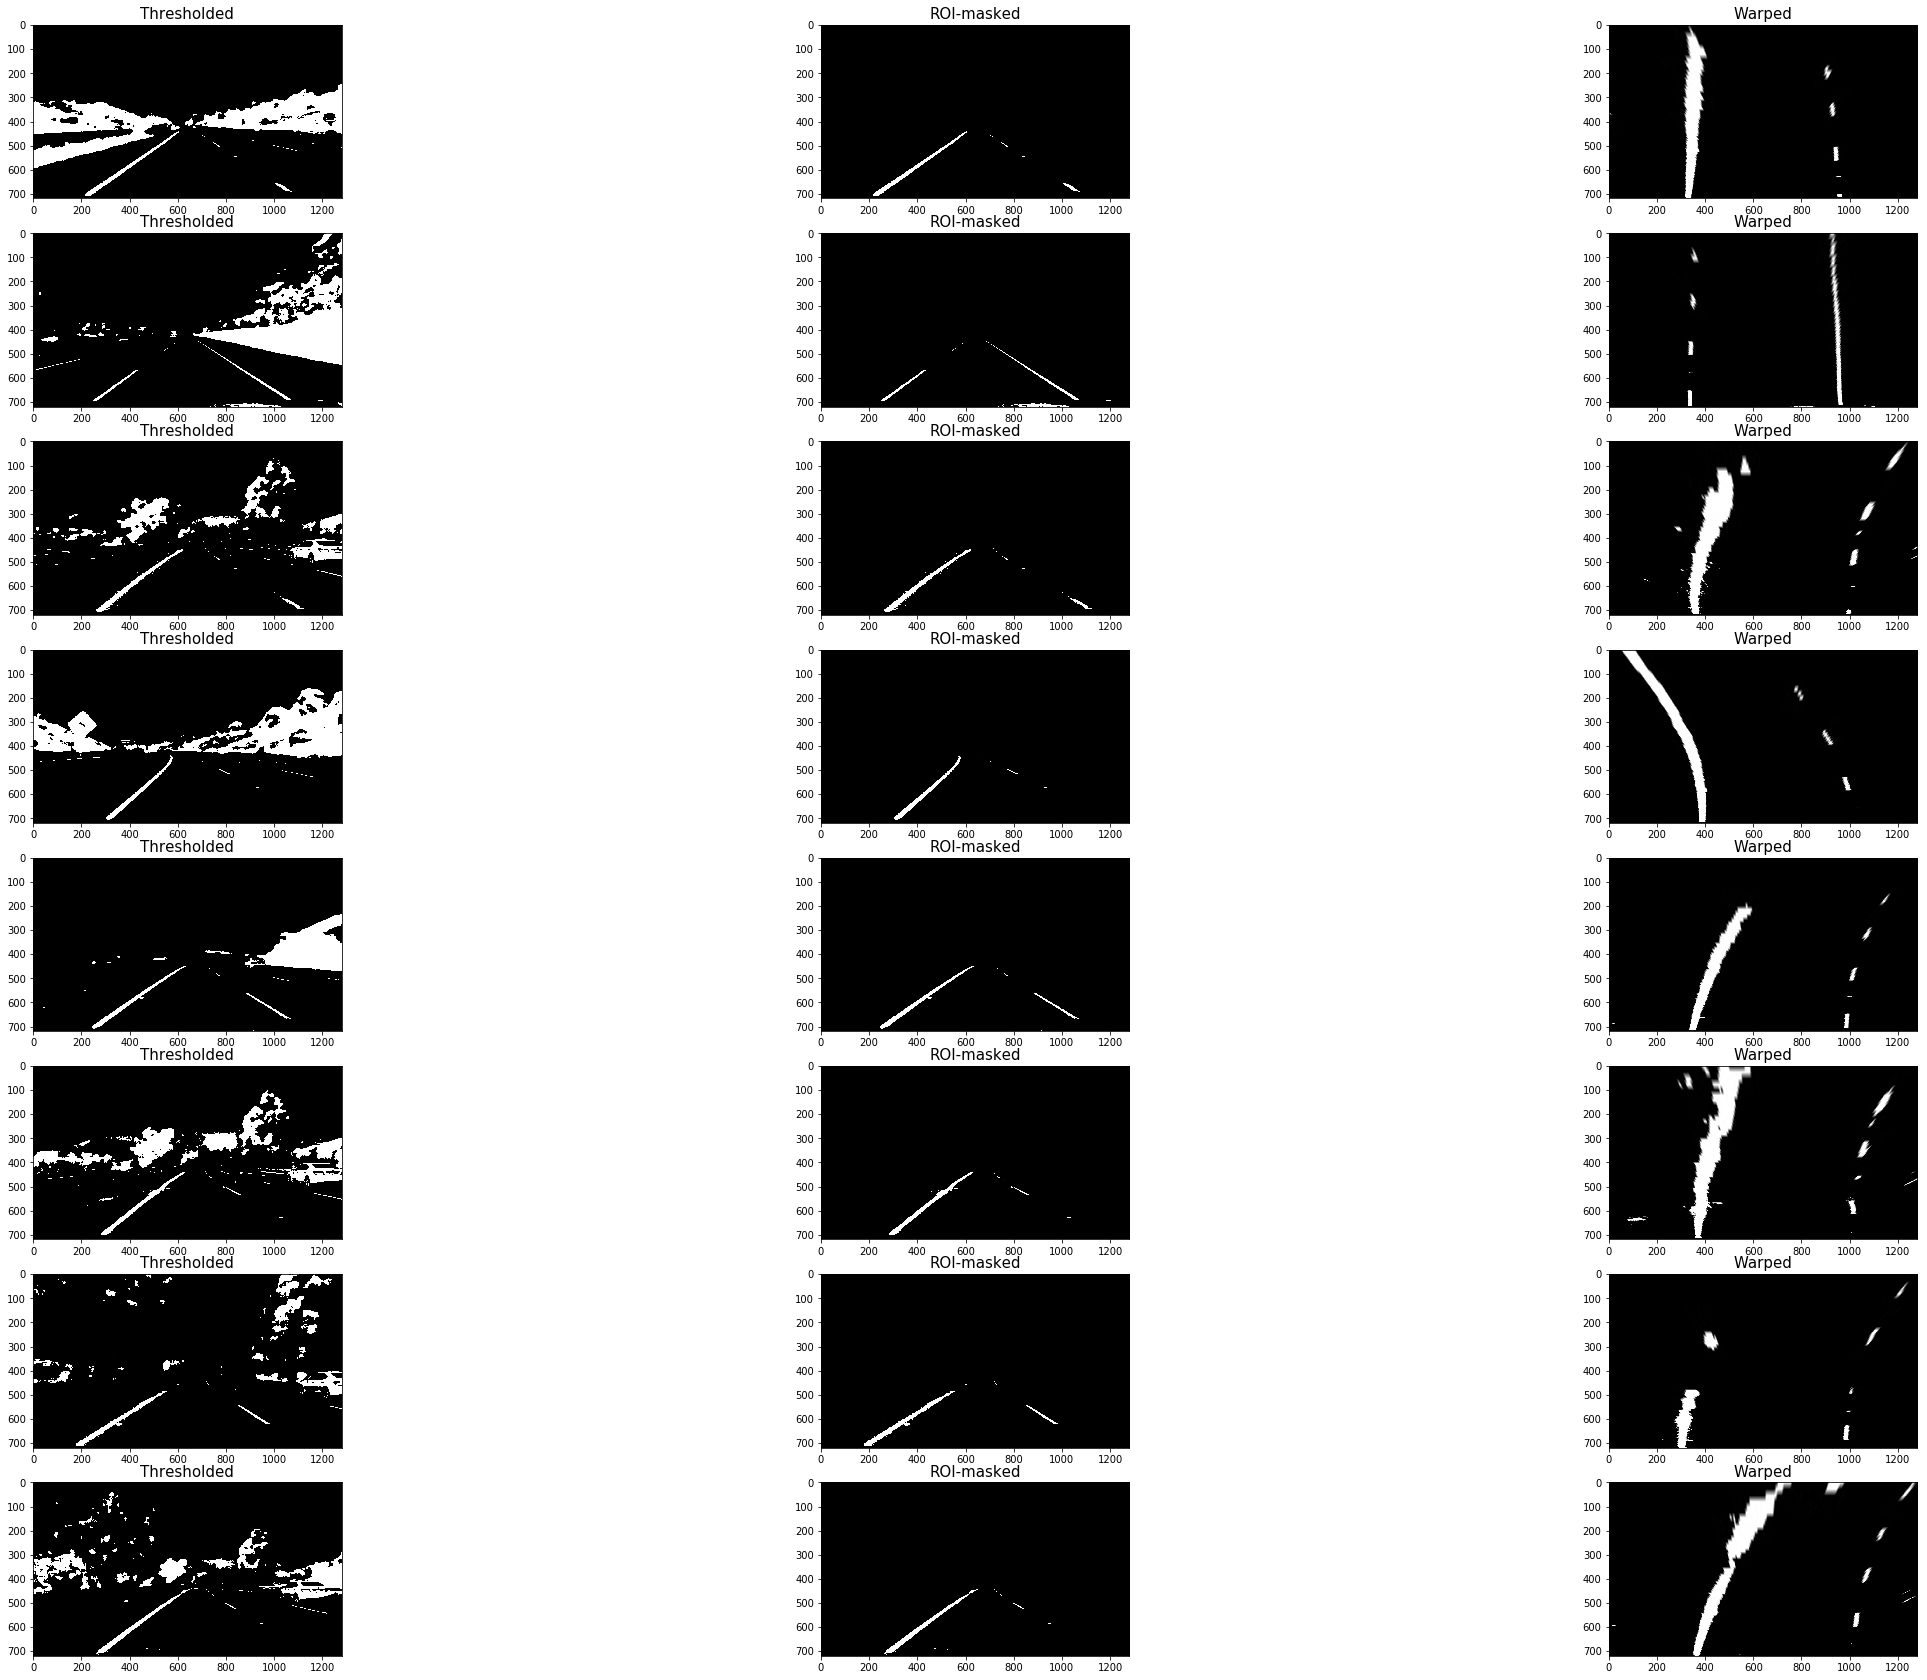

In [3]:
def region_of_interest(img, vertices):
    """
    Applies an image mask. Borrowed from Project 1.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        polygon_color = (255,) * channel_count
    else:
        polygon_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, polygon_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def cal_warp(img_thresh):
    """
    pipeline
    """
    #gray = cv2.cvtColor(img_thresh, cv2.COLOR_BGR2GRAY)
    gray = img_thresh
    img_size = (gray.shape[1], gray.shape[0])
    # 0) source points and destination points    
    vertices = np.array([[(565, 442),\
                     (720, 442), \
                     (1280, 720), \
                     (26, 720)]], dtype=np.int32)
    #vertices = np.array([[(595, 450),\
    #                 (685, 450), \
    #                 (1100, 720), \
    #                 (200, 720)]], dtype=np.int32)
    #vertices = np.array([[(595, 446),\
    #                 (720, 446), \
    #                 (1254, 720), \
    #                 (26, 720)]], dtype=np.int32)
    src = np.squeeze(vertices.astype('float32'))
    #offset = (720-676)*1280//720.
    offset = 200
    dst = np.array([[(0+offset/10, 0.),\
                    (1280, 0.),\
                    (1280-offset, 720),\
                    (0+offset, 720)]], dtype=np.float32)
    #dst = np.array([[(300, 0.),\
    #                (980, 0.),\
    #                (980, 720),\
    #                (300, 720)]], dtype=np.float32)
    #dst = np.array([[(0+offset, 0.),\
    #                (1280-offset, 0.),\
    #                (1280-2*offset, 720),\
    #                (0, 720)]], dtype=np.float32)
    dst = np.squeeze(dst)
 
    masked_edges = region_of_interest(img_thresh, vertices)
    #cv2.imwrite('special_roi.jpg',masked_edges)
    
    
    # 1) use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # 2) use cv2.warpPerspective() to warp your image to a top-down view
    #warped = cv2.warpPerspective(masked_edges, M, img_size)
    #cv2.imwrite('special_warped.jpg',warped)
    warped = cv2.warpPerspective(img_thresh, M, img_size)
    return warped, M, Minv, masked_edges

# Step through the list of test images
for i in range(6):
    img_thresh = cv2.imread("test_images/test_thresh"+str(i+1)+".jpg")
    warped, M, Minv, masked_edges = cal_warp(img_thresh)
    cv2.imwrite('test_images/test_warped'+str(i+1)+'.jpg',warped)
    cv2.imwrite('test_images/test_roi'+str(i+1)+'.jpg',masked_edges)
for i in range(2):
    img_thresh = cv2.imread("test_images/straight_lines_thresh"+str(i+1)+".jpg")
    warped, M, Minv, masked_edges = cal_warp(img_thresh)
    cv2.imwrite('test_images/straight_lines_warped'+str(i+1)+'.jpg',warped)
    cv2.imwrite('test_images/straight_lines_roi'+str(i+1)+'.jpg',masked_edges)
    
##############################################################################
# Visualize color- and gradient-thresholding of the undistorted images
%matplotlib inline
f, axes = plt.subplots(8, 3, figsize=(40,30))
for i in range(2):
    axes[i, 0].imshow(cv2.cvtColor(cv2.imread("test_images/straight_lines_thresh"+str(i+1)+".jpg"), cv2.COLOR_BGR2RGB))
    axes[i, 0].set_title('Thresholded', fontsize=15)
    axes[i, 1].imshow(cv2.cvtColor(cv2.imread('test_images/straight_lines_roi'+str(i+1)+'.jpg'), cv2.COLOR_BGR2RGB))
    axes[i, 1].set_title('ROI-masked', fontsize=15)
    axes[i, 2].imshow(cv2.cvtColor(cv2.imread('test_images/straight_lines_warped'+str(i+1)+'.jpg'), cv2.COLOR_BGR2RGB))
    axes[i, 2].set_title('Warped', fontsize=15)
for i in range(6):
    axes[i+2, 0].imshow(cv2.cvtColor(cv2.imread("test_images/test_thresh"+str(i+1)+".jpg"), cv2.COLOR_BGR2RGB))
    axes[i+2, 0].set_title('Thresholded', fontsize=15)
    axes[i+2, 1].imshow(cv2.cvtColor(cv2.imread('test_images/test_roi'+str(i+1)+'.jpg'), cv2.COLOR_BGR2RGB))
    axes[i+2, 1].set_title('ROI-masked', fontsize=15)
    axes[i+2, 2].imshow(cv2.cvtColor(cv2.imread('test_images/test_warped'+str(i+1)+'.jpg'), cv2.COLOR_BGR2RGB))
    axes[i+2, 2].set_title('Warped', fontsize=15)

---

### 2.3 Lane Lines: pixel identification and polyfitting them with a 2nd order polynomial
---

In [4]:
def cal_polyfit(img_warped, window_width):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the imag
    #binary_warped = img_warped[:,:,0]
    binary_warped = img_warped
#    binary_warped_1st_half = img_warped[img_warped.shape[0]//2:,:]
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    #plot_debug(histogram, 'histogram')
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    #print(leftx_base, rightx_base)
    
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = window_width # 100. When in 1st iteration, window should be a bit wider (100) than what is used in later iterations (60)
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) \
                          & (nonzeroy < win_y_high) \
                          & (nonzerox >= win_xleft_low) \
                          & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) \
                           & (nonzeroy < win_y_high) \
                           & (nonzerox >= win_xright_low) \
                           & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        #print(left_lane_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean positions
        if (len(good_left_inds) > minpix):
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if (len(good_right_inds) > minpix):
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    #print(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    #print(left_lane_inds.shape)
    #print(right_lane_inds.shape)
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return histogram, out_img, left_fit, right_fit, nonzerox, nonzeroy, left_lane_inds, right_lane_inds


In [5]:
# Look Ahead Filter (LAF)
def cal_polyfit_LAF(img_warped, left_fit, right_fit, window_width):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    binary_warped = img_warped
    left_fit_new = None;
    right_fit_new = None;
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = window_width # 60
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + \
                                   left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + \
                                                                         left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + \
                                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + \
                                                                           right_fit[1]*nonzeroy + right_fit[2] + margin)))  
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit_new = np.polyfit(lefty, leftx, 2)
    right_fit_new = np.polyfit(righty, rightx, 2)
    
    return histogram, out_img, left_fit_new, right_fit_new, nonzerox, nonzeroy, left_lane_inds, right_lane_inds

In [6]:
def plot_lanes(img_warped, out_img, left_fit, right_fit, nonzerox, nonzeroy, left_lane_inds, right_lane_inds, window_width):
    # Generate x and y values for plotting
    binary_warped = img_warped
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to show the (curved) selection window
    window_img = np.zeros_like(out_img)
    margin = window_width # 60
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    # Draw the polyfit curves onto the detected lane pixels
    yellow_pts1 = np.int_(np.array([np.transpose(np.vstack([left_fitx, ploty]))]))
    yellow_pts2 = np.int_(np.array([np.transpose(np.vstack([right_fitx, ploty]))]))
    
    cv2.polylines(img=out_img, pts=yellow_pts1, isClosed=0, color=(127,255,255), thickness=16)
    cv2.polylines(img=out_img, pts=yellow_pts2, isClosed=0, color=(127,255,255), thickness=16)
    #out_img[ploty.astype(np.int32), np.rint(left_fitx).astype(np.int32)] = [0, 255, 255]
    #out_img[ploty.astype(np.int32), np.rint(right_fitx).astype(np.int32)] = [0, 255, 255]
    
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    
    return result,ploty,left_fitx,right_fitx

In [7]:
window_width = 100
# Step through the list of test images
for i in range(6):
    #img_warped = cv2.imread("test_images/test_warped"+str(i+1)+".jpg", 0)
    img = cv2.imread("test_images/test_undist"+str(i+1)+".jpg")
    dst = color_grad_thresh(img)
    warped, M, Minv, masked_edges = cal_warp(dst)
    histogram, out_img, left_fit, right_fit, nonzerox, nonzeroy, left_lane_inds, right_lane_inds= cal_polyfit(warped, window_width)
    plt.figure()
    plt.plot(histogram)
    plt.savefig('test_images/test_hist'+str(i+1)+'.jpg')
    plt.close()
    result,ploty,left_fitx,right_fitx = plot_lanes(warped, out_img, left_fit, right_fit, nonzerox, nonzeroy, left_lane_inds, right_lane_inds, window_width)
    cv2.imwrite('test_images/test_window'+str(i+1)+'.jpg',result)

for i in range(2):
    #img_warped = cv2.imread("test_images/straight_lines_warped"+str(i+1)+".jpg",0)
    img = cv2.imread("test_images/straight_lines_undist"+str(i+1)+".jpg")
    dst = color_grad_thresh(img)
    warped, M, Minv, masked_edges = cal_warp(dst)
    histogram2, out_img, left_fit, right_fit, nonzerox, nonzeroy, left_lane_inds, right_lane_inds= cal_polyfit(warped, window_width)
    plt.figure()
    plt.plot(histogram2)
    plt.savefig('test_images/straight_lines_hist'+str(i+1)+'.jpg')
    plt.close()
    result,ploty,left_fitx,right_fitx = plot_lanes(warped, out_img, left_fit, right_fit, nonzerox, nonzeroy, left_lane_inds, right_lane_inds, window_width)
    cv2.imwrite('test_images/straight_lines_window'+str(i+1)+'.jpg',result)

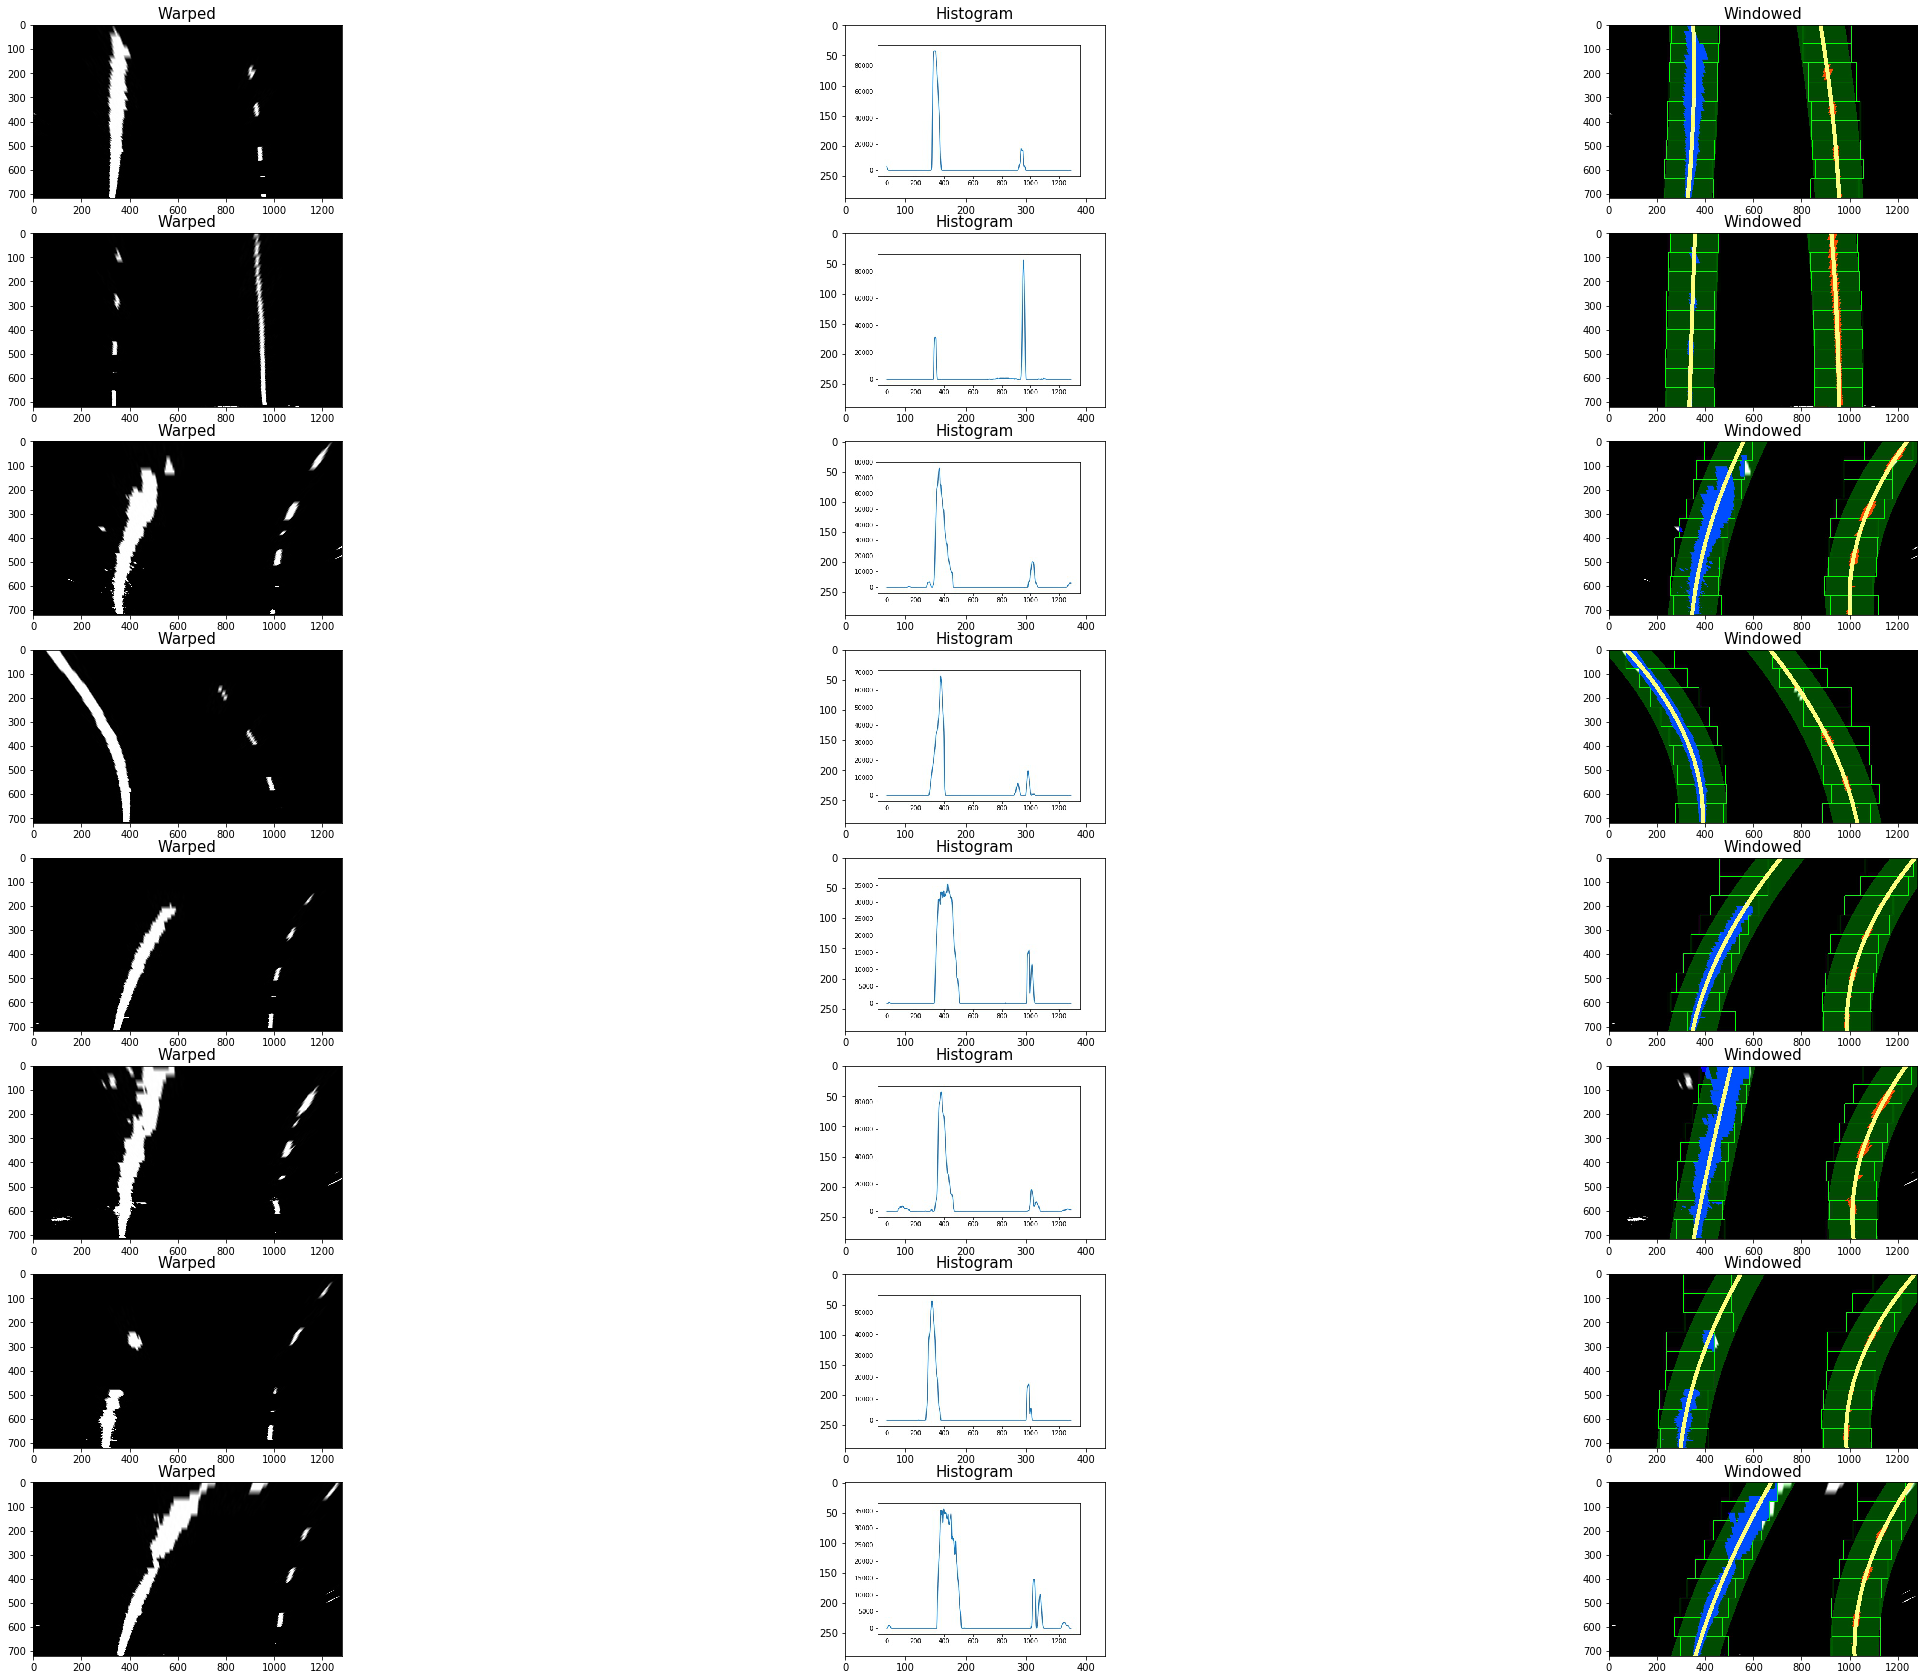

In [8]:
#####################################################################
# Visualize the histograms, left and right lanes
%matplotlib inline
f, axes = plt.subplots(8, 3, figsize=(40,30))
for i in range(2):
    axes[i, 0].imshow(cv2.cvtColor(cv2.imread('test_images/straight_lines_warped'+str(i+1)+'.jpg'), cv2.COLOR_BGR2RGB))
    axes[i, 0].set_title('Warped', fontsize=15)
    axes[i, 1].imshow(cv2.cvtColor(cv2.imread('test_images/straight_lines_hist'+str(i+1)+'.jpg'), cv2.COLOR_BGR2RGB))
    axes[i, 1].set_title('Histogram', fontsize=15)
    axes[i, 2].imshow(cv2.cvtColor(cv2.imread('test_images/straight_lines_window'+str(i+1)+'.jpg'), cv2.COLOR_BGR2RGB))
    axes[i, 2].set_title('Windowed', fontsize=15)
for i in range(6):
    axes[i+2, 0].imshow(cv2.cvtColor(cv2.imread('test_images/test_warped'+str(i+1)+'.jpg'), cv2.COLOR_BGR2RGB))
    axes[i+2, 0].set_title('Warped', fontsize=15)
    axes[i+2, 1].imshow(cv2.cvtColor(cv2.imread('test_images/test_hist'+str(i+1)+'.jpg'), cv2.COLOR_BGR2RGB))
    axes[i+2, 1].set_title('Histogram', fontsize=15)
    axes[i+2, 2].imshow(cv2.cvtColor(cv2.imread('test_images/test_window'+str(i+1)+'.jpg'), cv2.COLOR_BGR2RGB))
    axes[i+2, 2].set_title('Windowed', fontsize=15)


---

### 2.4 Lane Lines: radius of curvature & plotting the lane lines back to the original images
---

Note: even with numerous fine-tuning of the size of the source and destination points, blah blah blah, curvatures of consecutive frames may still be inconsistent (for example, the left radius of curvature of 'test1.jpg' and 'test2.jpg'). In other words, we have 'outliers'. So we need
* Outlier detection
* Sanity check
* Smoothing

In [18]:
def cal_curvature(img_warped, left_fit, right_fit, nonzerox, nonzeroy, left_lane_inds, right_lane_inds):
    """
    -'ym_per_pix' is measured from 'test_images/straight_lines_window2.jpg' while 
                 'the dashed lane lines are 10 feet or 3 meters long each.' is considered
    -'xm_per_pix' is measured from 'test_images/test_window2.jpg' while "U.S. regulations 
                that require a minimum lane width of 12 feet or 3.7 meters" is also considered
    """
    # Define conversions in x and y from pixels space to meters
    #ym_per_pix = 3/72 # meters per pixel in y dimension
    #xm_per_pix = 3.7/700 # meters per pixel in x dimension
    #ym_per_pix = 3/57 # meters per pixel in y dimension (measured from 'test_warped3.jpg')
    ym_per_pix = 40/720 # meters per pixel in y dimension (measured from 'test_warped3.jpg')
    xm_per_pix = 3.7/620 # meters per pixel in x dimension

    # Generate x and y values
    binary_warped = img_warped
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    
    ## Lane pixels detected
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    ## Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Define y-value where we want radius of curvature
    # I'll choose the half of the maximumal y value, corresponding to the middle of the image
    y_eval = np.max(ploty)
    #y_eval = ploty[binary_warped.shape[0]//2]
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    #left_curverad_0 = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0]) * ( 1546.35934228 /  2755.18076472)
    #right_curverad_0 = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0]) * ( 1546.35934228 /  2755.18076472)
    
    # Calculate offset
    ## Using only the bottom position of the left- and right- lane lines for computation of lane center
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    lane_center = (left_fitx[binary_warped.shape[0]-1] + right_fitx[binary_warped.shape[0]-1]) // 2 
    offset = (binary_warped.shape[1]//2 -lane_center) * xm_per_pix
    
    #return left_curverad, right_curverad, left_curverad_0, right_curverad_0, offset
    #return left_curverad_0, right_curverad_0, offset
    return left_curverad, right_curverad, offset
    
    
# Step through the list of test images
for i in range(2):
    img_warped = cv2.imread("test_images/straight_lines_warped"+str(i+1)+".jpg", 0)
    histogram, out_img, left_fit, right_fit, nonzerox, nonzeroy, left_lane_inds, right_lane_inds= cal_polyfit(img_warped, 100)
    #left_curverad_0, right_curverad_0, offset = cal_curvature(img_warped, left_fit, right_fit, nonzerox, nonzeroy, left_lane_inds, right_lane_inds)
    left_curverad, right_curverad, offset = cal_curvature(img_warped, left_fit, right_fit, nonzerox, nonzeroy, left_lane_inds, right_lane_inds)
    #left_curverad, right_curverad, left_curverad_0, right_curverad_0, offset = cal_curvature(img_warped, left_fit, right_fit, nonzerox, nonzeroy, left_lane_inds, right_lane_inds)
    print('Radius of curvature: left=', left_curverad, 'm, right=', right_curverad, 'm')
    #print('Radius of curvature: left=', left_curverad_0, 'm, right=', right_curverad_0, 'm')
    print('Vehicle is', offset, 'm left of center')
for i in range(6):
    img_warped = cv2.imread("test_images/test_warped"+str(i+1)+".jpg", 0)
    histogram, out_img, left_fit, right_fit, nonzerox, nonzeroy, left_lane_inds, right_lane_inds= cal_polyfit(img_warped, 100)
    #left_curverad_0, right_curverad_0, offset = cal_curvature(img_warped, left_fit, right_fit, nonzerox, nonzeroy, left_lane_inds, right_lane_inds)
    left_curverad, right_curverad, offset = cal_curvature(img_warped, left_fit, right_fit, nonzerox, nonzeroy, left_lane_inds, right_lane_inds)
    #left_curverad, right_curverad, left_curverad_0, right_curverad_0, offset = cal_curvature(img_warped, left_fit, right_fit, nonzerox, nonzeroy, left_lane_inds, right_lane_inds)
    haha = "Radius of curvature: left="+str(left_curverad)+"m, right="+str(right_curverad)+"m"
    print(haha)
    #haha_0 = "Radius of curvature: left="+str(left_curverad_0)+"m, right="+str(right_curverad_0)+"m"
    #print(haha_0)
    #print('Radius of curvature: left=', left_curverad, 'm, right=', right_curverad, 'm')
    print('Vehicle is', offset, 'm left of center')

Radius of curvature: left= 1231.91867051 m, right= 1396.75594506 m
Vehicle is 0.0477419354839 m left of center
Radius of curvature: left= 55470.1846903 m, right= 155838.776 m
Vehicle is -0.0417741935484 m left of center
Radius of curvature: left=9346.55459332m, right=475.513689607m
Vehicle is -0.137258064516 m left of center
Radius of curvature: left=505.752850494m, right=250.669519556m
Vehicle is -0.608709677419 m left of center
Radius of curvature: left=2467.01964347m, right=441.57124636m
Vehicle is -0.11935483871 m left of center
Radius of curvature: left=4408.12923839m, right=519.403765395m
Vehicle is -0.220806451613 m left of center
Radius of curvature: left=765.650897207m, right=442.732517809m
Vehicle is 0.0656451612903 m left of center
Radius of curvature: left=2607.00777429m, right=612.873261404m
Vehicle is -0.238709677419 m left of center


In [10]:
#########################################################
def project_back(undist, warped, Minv, left_fit, right_fit):
    binary_warped = warped
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw the lines on
    binary_warped = warped
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (binary_warped.shape[1], binary_warped.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result
    
for i in range(6):
    img_undistorted = cv2.imread("test_images/test_undist"+str(i+1)+".jpg")
    img_thresholded = cv2.imread("test_images/test_thresh"+str(i+1)+".jpg", 0)
    img_warped, M, Minv, masked_edges = cal_warp(img_thresholded)
    histogram, out_img, left_fit, right_fit, nonzerox, nonzeroy, left_lane_inds, right_lane_inds= cal_polyfit(img_warped, 100)
    result = project_back(img_undistorted, img_warped, Minv, left_fit, right_fit)
    cv2.imwrite('test_images/test_projectback'+str(i+1)+'.jpg',result)
    
for i in range(2):
    img_undistorted = cv2.imread("test_images/straight_lines_undist"+str(i+1)+".jpg")
    img_thresholded = cv2.imread("test_images/straight_lines_thresh"+str(i+1)+".jpg", 0)
    warped, M, Minv, masked_edges = cal_warp(img_thresholded)
    histogram, out_img, left_fit, right_fit, nonzerox, nonzeroy, left_lane_inds, right_lane_inds= cal_polyfit(img_warped, 100)
    result = project_back(img_undistorted, img_warped, Minv, left_fit, right_fit)
    cv2.imwrite('test_images/straight_lines_projectback'+str(i+1)+'.jpg',result) 

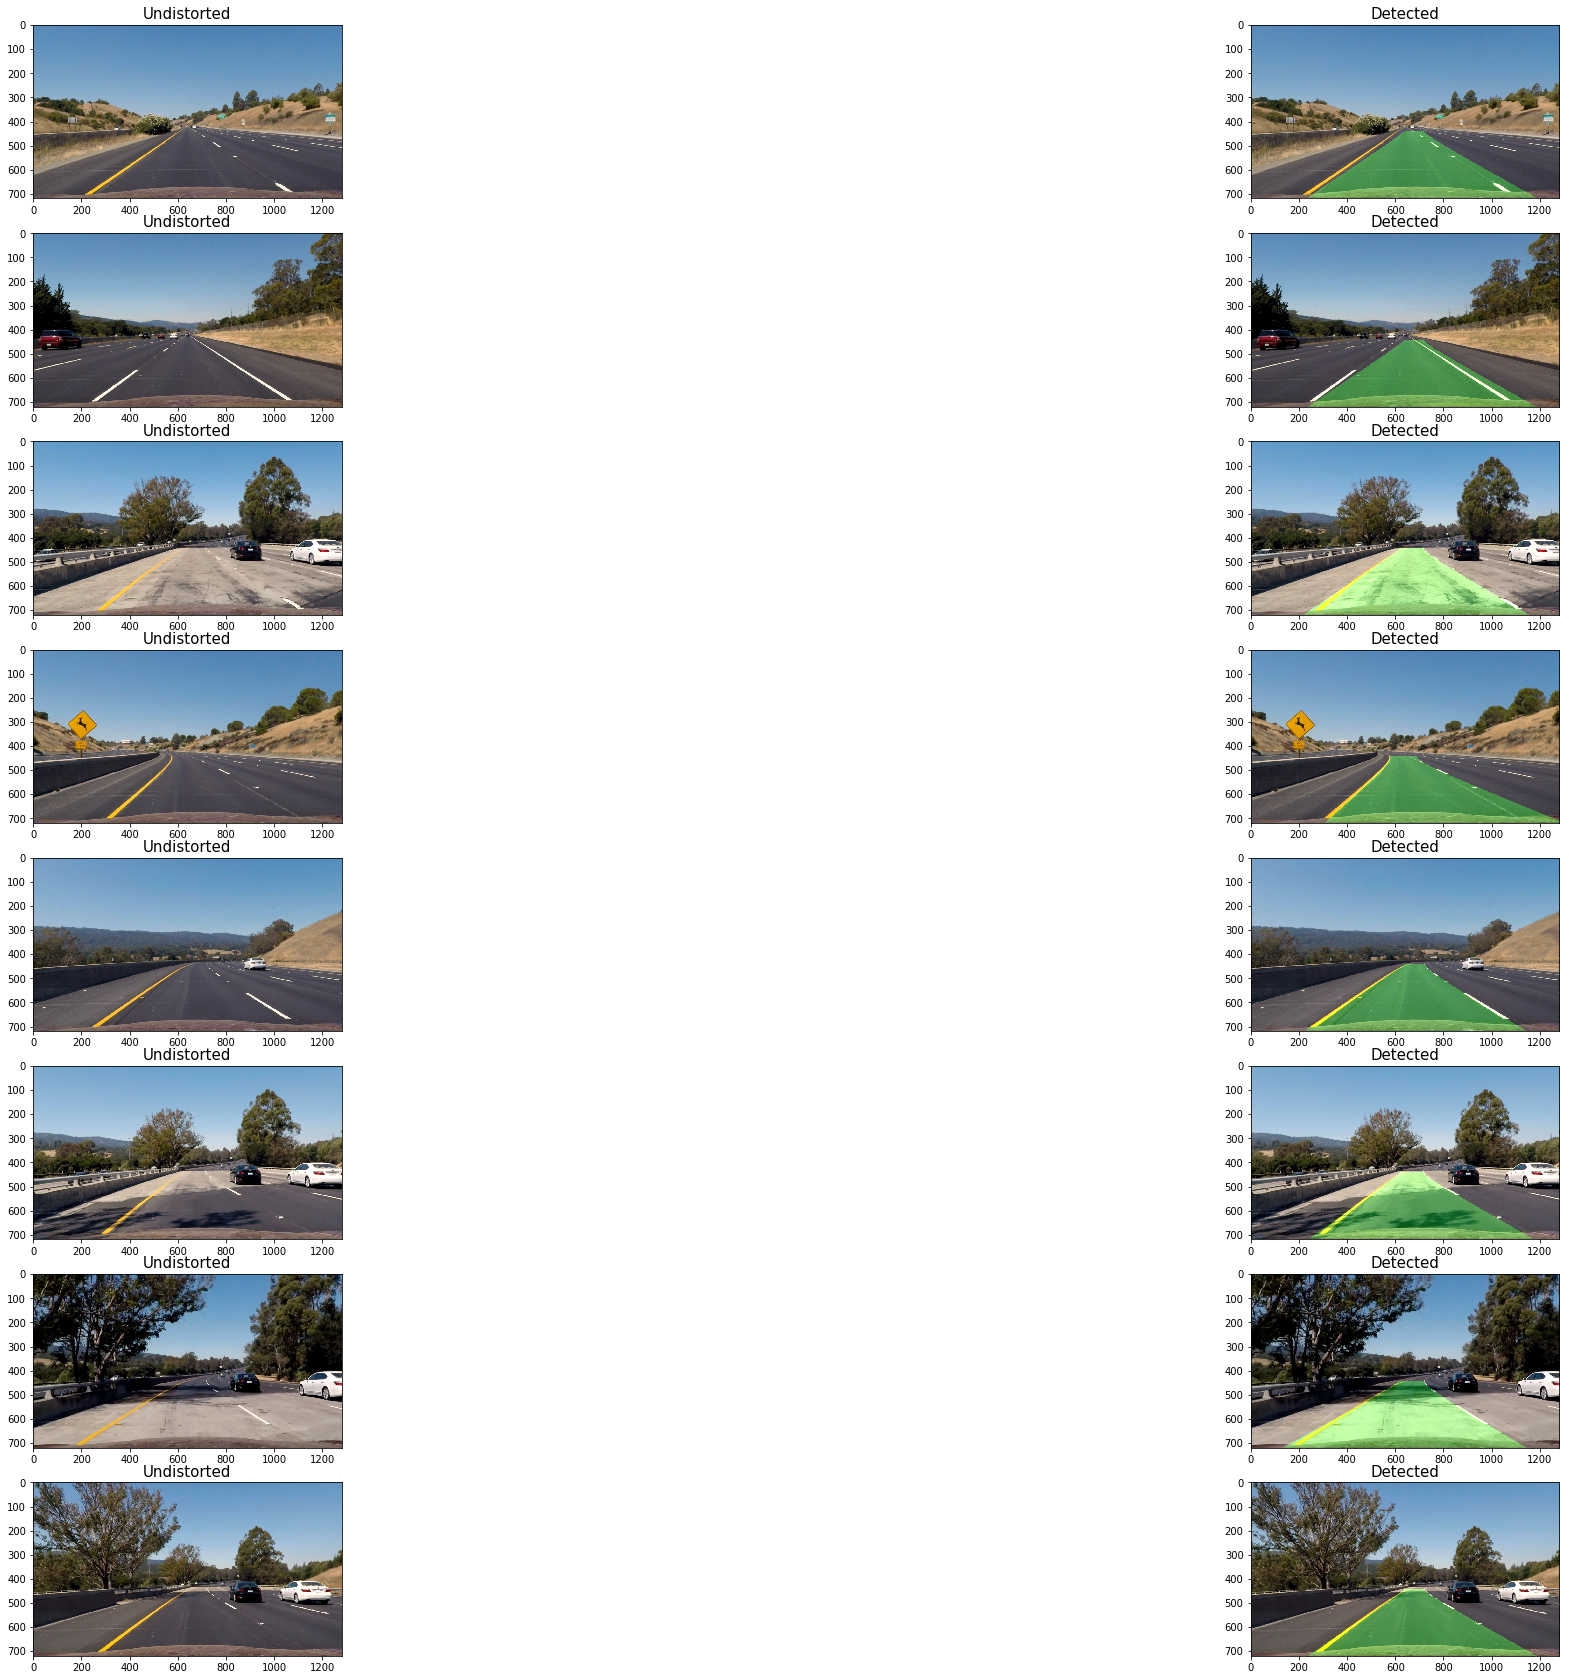

In [11]:
#################################################
# Visualize lanes overlapped with color polygon
%matplotlib inline
f, axes = plt.subplots(8, 2, figsize=(40,30))
for i in range(2):
    axes[i, 0].imshow(cv2.cvtColor(cv2.imread('test_images/straight_lines_undist'+str(i+1)+'.jpg'), cv2.COLOR_BGR2RGB))
    axes[i, 0].set_title('Undistorted', fontsize=15)
    axes[i, 1].imshow(cv2.cvtColor(cv2.imread('test_images/straight_lines_projectback'+str(i+1)+'.jpg'), cv2.COLOR_BGR2RGB))
    axes[i, 1].set_title('Detected', fontsize=15)
for i in range(6):
    axes[i+2, 0].imshow(cv2.cvtColor(cv2.imread('test_images/test_undist'+str(i+1)+'.jpg'), cv2.COLOR_BGR2RGB))
    axes[i+2, 0].set_title('Undistorted', fontsize=15)
    axes[i+2, 1].imshow(cv2.cvtColor(cv2.imread('test_images/test_projectback'+str(i+1)+'.jpg'), cv2.COLOR_BGR2RGB))
    axes[i+2, 1].set_title('Detected', fontsize=15)

---

## 3. Pipeline (video)

---

In [12]:
from collections import deque
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False
        
        # xin: polynomial coefficients of the last n fits of the line
        self.cum_sum_coef = np.array([0,0,0], dtype='float')
        self.recent_coef10 = deque()
        #polynomial coefficients averaged over the last n iterations
        self.best_coef = np.array([0,0,0], dtype='float')  
        #polynomial coefficients for the most recent fit
        self.current_coef = None
        # xin: polynomial coefficients for last fit
        self.last_coef = np.zeros((3,), dtype = np.float)
        #self.last_fit = [np.array([False])]
        
        #radius of curvature of the line in some units
        self.radius_of_curvature = np.float(0.0)
        self.last_radius_of_curvature = np.float(0.0)
        #distance in meters of vehicle center from the line
        self.line_base_pos = np.float(0.0)


In [13]:
from collections import deque

def running_average10(deque_data, new_data, cum_sum):
    if len(deque_data) == 10:
        old_value = deque_data.popleft()
        cum_sum -= old_value
    cum_sum += new_data
    deque_data.append(new_data)
    running_average = cum_sum / len(deque_data)
        
    return running_average

In [43]:
def sanity_check(img_warped, pt1, pt2):
    """
       Check in two dimensions: across time (between two time steps); across lines (between left and right lane lines)
       - Checking that they have similar curvature (absolute values)
       - Checking that they have similar curvature (signs)
       - Checking that they are separated by approximately the right distance horizontally
       
       Note:
       # Thresholds: lots of thresholds need collecting in this function 2017-11-07
       # xm_per_pix: check 'cal_curvature' for consistency
    """
    # Define conversions in x and y from pixels space to meters, check 'cal_curvature' for consistency
    #xm_per_pix = 3.7/700 # meters per pixel in x dimension
    xm_per_pix = 3.7/620 # meters per pixel in x dimension
    
    # Thresholds: lots of thresholds need collecting in this function
    #thresh_curvature_LF = 1200 # left and right threshold
    thresh_curvature_LF = 2000 # left and right threshold
    thresh_curvature_TT = 0.5 # threshold between two consecutive epochs
    
    # Buffer saving the preceding n results
    ploty = np.linspace(0, img_warped.shape[0]-1, img_warped.shape[0])
    if pt1.current_coef != None:
        #print("hi-2.1")
        pt1.detected = True
        left_fitx = pt1.current_coef[0]*ploty**2 + pt1.current_coef[1]*ploty + pt1.current_coef[2]
        
    if pt2.current_coef != None:
        #print("hi-2.1")
        pt2.detected = True
        right_fitx = pt2.current_coef[0]*ploty**2 + pt2.current_coef[1]*ploty + pt2.current_coef[2]   
    
    # check lane width
    if abs(right_fitx[img_warped.shape[0]-1] - left_fitx[img_warped.shape[0]-1]) < 0.8 * 646:
        print("I got u")
        pt1.current_coef = pt1.best_coef
        pt2.current_coef = pt2.best_coef
        
    if pt1.radius_of_curvature < thresh_curvature_LF and pt2.radius_of_curvature < thresh_curvature_LF:
        # check curvature (sign)
        left_tangent = 2*pt1.current_coef[0]*ploty + pt1.current_coef[1]
        right_tangent = 2*pt2.current_coef[0]*ploty + pt2.current_coef[1]
        tangent_with_reverse_sign = np.asarray(np.where(np.multiply(left_tangent, right_tangent) < 0.0))
        #print(np.squeeze(tangent_with_reverse_sign, axis=0))
        if np.squeeze(tangent_with_reverse_sign, axis=0).shape[0] > (0.5*720):
            print("AA_sign!")
            pt1.current_coef = pt1.best_coef
            pt2.current_coef = pt2.best_coef
        # check curvature (magnitude)
        if abs(pt1.radius_of_curvature / pt2.radius_of_curvature) < thresh_curvature_TT:
            print("AA_mag_left!")
            pt1.current_coef = pt1.best_coef
        if abs(pt2.radius_of_curvature / pt1.radius_of_curvature) < thresh_curvature_TT:
            print("AA_mag_right!")
            pt2.current_coef = pt2.best_coef

        a1 = min(pt1.radius_of_curvature, pt1.last_radius_of_curvature)
        if a1 > 0.001:
            if abs((pt1.last_radius_of_curvature - pt1.radius_of_curvature)/a1) > 2.0:
                print("TT_left")
                #pt1.current_coef = pt1.best_coef
                pt1.current_coef = pt1.last_coef
        a2 = min(pt2.radius_of_curvature, pt2.last_radius_of_curvature)
        if a2 > 0.001:
            if abs((pt2.last_radius_of_curvature - pt2.radius_of_curvature)/a2) > 2.0:
                print("TT_right")
                pt2.current_coef = pt2.best_coef
        #if pt1.best_coef[0]*pt1.current_coef[0] < 0.0:
        #    print("aha 1")
        #    #pt1.current_coef = pt1.best_coef
        #    pt1.current_coef = pt1.last_coef
        #if pt2.best_coef[0]*pt2.current_coef[0] < 0.0:
        #    print("aha 2")
        #    #pt2.current_coef = pt2.best_coef
        #    pt2.current_coef = pt2.last_coef
        if pt1.current_coef[0]*pt2.current_coef[0] < 0.0:
            pass
        
    if pt1.radius_of_curvature < thresh_curvature_LF and pt2.radius_of_curvature > thresh_curvature_LF:
        a1 = min(pt1.radius_of_curvature, pt1.last_radius_of_curvature)
        if a1 > 0.001:
            if abs((pt1.last_radius_of_curvature - pt1.radius_of_curvature)/a1) > 2.0:
                print("aA_left")
                pt1.current_coef = pt1.best_coef
        a2 = min(pt2.radius_of_curvature, pt2.last_radius_of_curvature)
        if a2 > 0.001:
            if abs((pt2.last_radius_of_curvature - pt2.radius_of_curvature)/a2) > 2.0:
                print("aA_right")
                pt2.current_coef = pt2.best_coef
        if pt1.best_coef[0]*pt1.current_coef[0] < 0.0:
            print("hello 25 32 3")
            pt1.current_coef = pt1.best_coef
            
    if pt1.radius_of_curvature > thresh_curvature_LF and pt2.radius_of_curvature < thresh_curvature_LF:
        a1 = min(pt1.radius_of_curvature, pt1.last_radius_of_curvature)
        if a1 > 0.001:
            if abs((pt1.last_radius_of_curvature - pt1.radius_of_curvature)/a1) > 2.0:
                print("aA_left")
                pt1.current_coef = pt1.best_coef
        a2 = min(pt2.radius_of_curvature, pt2.last_radius_of_curvature)
        if a2 > 0.001:
            if abs((pt2.last_radius_of_curvature - pt2.radius_of_curvature)/a2) > 2.0:
                print("aA_right")
                pt2.current_coef = pt2.best_coef
        if pt2.best_coef[0]*pt2.current_coef[0] < 0.0:
            print("hello 25 32 4")
            pt2.current_coef = pt2.best_coef
    
    
    #polynomial coefficients averaged over the last n iterations
    pt1.best_coef = running_average10(pt1.recent_coef10, pt1.current_coef, pt1.cum_sum_coef)
    pt2.best_coef = running_average10(pt2.recent_coef10, pt2.current_coef, pt2.cum_sum_coef)

    #polynomial coefficients for the most recent fit
    pt1.last_coef = pt1.current_coef
    pt2.last_coef = pt2.current_coef
    pt1.last_radius_of_curvature = pt1.radius_of_curvature
    pt2.last_radius_of_curvature = pt2.radius_of_curvature
    
    # upddate the offset
    left_fitx = pt1.current_coef[0]*ploty**2 + pt1.current_coef[1]*ploty + pt1.current_coef[2]
    right_fitx = pt2.current_coef[0]*ploty**2 + pt2.current_coef[1]*ploty + pt2.current_coef[2]
    lane_center = (left_fitx[img_warped.shape[0]-1] + right_fitx[img_warped.shape[0]-1]) // 2 
    pt1.line_base_pos = (img_warped.shape[1]//2 -lane_center) * xm_per_pix
    pt2.line_base_pos = pt1.line_base_pos
    
    
    
    return pt1, pt2
    

In [46]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from collections import deque

class MyVideoProcessor(object):
    myLeftLineObject = Line()
    myRightLineObject = Line()

    def process_image(self, img):
        pt1 = self.myLeftLineObject
        pt2 = self.myRightLineObject
        window_width_0 = 100 # search window width, [-50, 50] (pixels)
        window_width_1 = 80  # search window width, [-50, 50] (pixels) Note: Too small will limit the algorithm's
                              # ability to 'track' the x-axis 'movement' of the lane pixels
        
        #################################### pipeline ##########################################
        # Undistortion
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        img_undistorted = cal_undistort(img, objpoints, imgpoints)
        img_undistorted = cv2.cvtColor(img_undistorted, cv2.COLOR_BGR2RGB)
        #cv2.imwrite("special_undistort.jpg",img_undistorted)
        # Color space exploration
        img_thresholded = color_grad_thresh(img)
        #cv2.imwrite("special_thresh.jpg",img_thresholded)
        # Cropping and perspective transformation
        img_warped, M, Minv, masked_edges = cal_warp(img_thresholded)
        #cv2.imwrite("special_roi.jpg",masked_edges)
        #cv2.imwrite("special_warped.jpg",img_warped)
        # Polyfitting 
        if pt1.current_coef == None or pt2.current_coef == None: # for 1st iteration. Also shows what to follow if resetting is signaled
            print("hi-0")
            ## preparation for sanity check
            # Polynomials
            histogram, out_img, pt1.current_coef, pt2.current_coef, nonzerox, nonzeroy, left_lane_inds, right_lane_inds = cal_polyfit(img_warped,window_width_0)
            # Computing curvature
            pt1.radius_of_curvature, pt2.radius_of_curvature, offset = cal_curvature(img_warped, pt1.current_coef, pt2.current_coef, nonzerox, nonzeroy, left_lane_inds, right_lane_inds)
            #pt1.line_base_pos = offset
            #pt2.line_base_pos = offset
            
            ## now check sanity
            pt1, pt2 = sanity_check(img_warped, pt1, pt2)
            # Visualization of (1) detected lane points without sanity check, (2) polynomials augmented by sanity check
            result,ploty,left_fitx,right_fitx = plot_lanes(img_warped, out_img, pt1.current_coef, pt2.current_coef, nonzerox, nonzeroy, left_lane_inds, right_lane_inds, window_width_0)
        else: # for 2nd iteration and so on
            print("hi-1")
            ## preparation for sanity check
            # Polynomials
            histogram, out_img, pt1.current_coef, pt2.current_coef, nonzerox, nonzeroy, left_lane_inds, right_lane_inds = cal_polyfit(img_warped,window_width_0)
            # Computing curvature
            pt1.radius_of_curvature, pt2.radius_of_curvature, offset = cal_curvature(img_warped, pt1.current_coef, pt2.current_coef, nonzerox, nonzeroy, left_lane_inds, right_lane_inds)
            pt1.line_base_pos = offset
            pt2.line_base_pos = offset
            ## now check sanity
            pt1, pt2 = sanity_check(img_warped, pt1, pt2)
            # Visualization of (1) detected lane points without sanity check, (2) polynomials augmented by sanity check
            result,ploty,left_fitx,right_fitx = plot_lanes(img_warped, out_img, pt1.current_coef, pt2.current_coef, nonzerox, nonzeroy, left_lane_inds, right_lane_inds, window_width_0)   
            if type(pt1.current_coef) == None or type(pt2.current_coef) == None: # If nothing is detected, then use the previous best fit
                print("wow") # sadly, you will not enter this code block if you are testing 'project_video.mp4'
                pt1.current_coef = pt1.best_coef
                pt2.current_coef = pt2.best_coef                            
        
        ## Projecting back
        #img_projectedback = project_back(img_undistorted, img_warped, Minv, pt1.best_coef, pt2.best_coef)
        img_projectedback = project_back(img_undistorted, img_warped, Minv, pt1.current_coef, pt2.current_coef)
        
        ########################################################################################
        # Adding texts
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(img=img_projectedback, text="Radius of curvature: left="+str(np.rint(pt1.radius_of_curvature).astype(np.int32))+"m, right="+str(np.rint(pt2.radius_of_curvature).astype(np.int32))+"m",\
                    org=(10,180), fontFace=font, fontScale=0.75, color=(255,255,255), thickness=1, lineType=cv2.LINE_AA)
        if pt1.line_base_pos > 0.0:
            cv2.putText(img=img_projectedback, text="Vehicle center is "+str(np.round(pt1.line_base_pos, 2))+"m right of lane center",\
                    org=(10,230), fontFace=font, fontScale=0.75, color=(255,255,255), thickness=1, lineType=cv2.LINE_AA)
        else:
            cv2.putText(img=img_projectedback, text="Vehicle center is "+str(np.round(np.abs(pt1.line_base_pos), 2))+"m left of lane center",\
                    org=(10,230), fontFace=font, fontScale=0.75, color=(255,255,255), thickness=1, lineType=cv2.LINE_AA)

        # Overlaying intermediate results: thresholded                     x-coordinates: 0,240
        bb = np.zeros_like(img_undistorted) # black background
        img1 = cv2.resize(img_thresholded, (240,135))
        for i in range(3):
            bb[0:135, 0:240, i] = img1[:,:]
            img_projectedback[0:135, 0:240, i] = np.zeros((135,240), np.int32)
        img_projectedback = cv2.add(img_projectedback, bb)

        # Overlaying intermediate results: ROI                                            243,483
        bb = np.zeros_like(img_undistorted) # black background
        img1 = cv2.resize(masked_edges, (240,135))
        for i in range(3):
            bb[0:135, 243:483, i] = img1[:,:]
            img_projectedback[0:135, 243:483, i] = np.zeros((135,240), np.int32)
        img_projectedback = cv2.add(img_projectedback, bb)

        # Overlaying intermediate results: ROI (warped)                                   486:726
        bb = np.zeros_like(img_undistorted) # black background
        img1 = cv2.resize(img_warped, (240,135))
        for i in range(3):
            bb[0:135, 486:726, i] = img1[:,:]
            img_projectedback[0:135, 486:726, i] = np.zeros((135,240), np.int32)
        img_projectedback = cv2.add(img_projectedback, bb)

        # Overlaying intermediate results: detected (windowed and polyfit)                729,969
        bb = np.zeros_like(img_undistorted) # black background
        img1 = cv2.resize(result, (240,135))
        for i in range(3):
            bb[0:135, 729:969, i] = img1[:,:,i]
            img_projectedback[0:135, 729:969, i] = np.zeros((135,240), np.int32)
        img_projectedback = cv2.add(img_projectedback, bb)

        return img_projectedback

#################################################################################
#my_video_processor_object = MyVideoProcessor()
#video_output = 'test_videos_output/project_video_output_2s.mp4'
### To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
### To do so add .subclip(start_second,end_second) to the end of the line below
### Where start_second and end_second are integer values representing the start and end of the subclip
### You may also uncomment the following line for a subclip of the first 3.5 seconds
#clip1 = VideoFileClip("test_videos/project_video.mp4").subclip(0,2) # If you succeed in this first 3.5 s in any of the videos, then you succeed for good
#white_clip = clip1.fl_image(my_video_processor_object.process_image) #NOTE: this function expects color images!!
#%time white_clip.write_videofile(video_output, audio=False)  

In [47]:
########################################################################
my_video_processor_object = MyVideoProcessor()
video_output = 'test_videos_output/project_video_output_sanity-curvature.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
clip1 = VideoFileClip("test_videos/project_video.mp4")
white_clip = clip1.fl_image(my_video_processor_object.process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(video_output, audio=False)    

hi-0
[MoviePy] >>>> Building video test_videos_output/project_video_output_sanity-curvature.mp4
[MoviePy] Writing video test_videos_output/project_video_output_sanity-curvature.mp4



  0%|          | 1/1261 [00:00<19:33,  1.07it/s]

hi-1



  0%|          | 2/1261 [00:01<19:43,  1.06it/s]

hi-1



  0%|          | 3/1261 [00:02<19:46,  1.06it/s]

hi-1



  0%|          | 4/1261 [00:03<19:44,  1.06it/s]

hi-1



  0%|          | 5/1261 [00:04<20:08,  1.04it/s]

hi-1



  0%|          | 6/1261 [00:05<19:52,  1.05it/s]

hi-1



  1%|          | 7/1261 [00:06<19:35,  1.07it/s]

hi-1



  1%|          | 8/1261 [00:07<19:22,  1.08it/s]

hi-1



  1%|          | 9/1261 [00:08<19:20,  1.08it/s]

hi-1



  1%|          | 10/1261 [00:09<19:13,  1.08it/s]

hi-1



  1%|          | 11/1261 [00:10<19:07,  1.09it/s]

hi-1



  1%|          | 12/1261 [00:11<19:16,  1.08it/s]

hi-1



  1%|          | 13/1261 [00:12<19:13,  1.08it/s]

hi-1



  1%|          | 14/1261 [00:13<19:24,  1.07it/s]

hi-1



  1%|          | 15/1261 [00:13<19:13,  1.08it/s]

hi-1



  1%|▏         | 16/1261 [00:14<19:11,  1.08it/s]

hi-1



  1%|▏         | 17/1261 [00:15<19:45,  1.05it/s]

hi-1



  1%|▏         | 18/1261 [00:16<19:44,  1.05it/s]

hi-1
AA_mag_left!



  2%|▏         | 19/1261 [00:17<19:26,  1.07it/s]

hi-1
AA_mag_left!



  2%|▏         | 20/1261 [00:18<19:11,  1.08it/s]

hi-1
AA_mag_left!



  2%|▏         | 21/1261 [00:19<19:01,  1.09it/s]

hi-1
AA_mag_left!



  2%|▏         | 22/1261 [00:20<19:02,  1.08it/s]

hi-1
AA_mag_left!



  2%|▏         | 23/1261 [00:21<19:09,  1.08it/s]

hi-1



  2%|▏         | 24/1261 [00:22<19:01,  1.08it/s]

hi-1



  2%|▏         | 25/1261 [00:23<18:56,  1.09it/s]

hi-1



  2%|▏         | 26/1261 [00:24<18:58,  1.08it/s]

hi-1



  2%|▏         | 27/1261 [00:25<18:50,  1.09it/s]

hi-1



  2%|▏         | 28/1261 [00:26<18:45,  1.10it/s]

hi-1



  2%|▏         | 29/1261 [00:26<18:43,  1.10it/s]

hi-1



  2%|▏         | 30/1261 [00:27<19:17,  1.06it/s]

hi-1



  2%|▏         | 31/1261 [00:28<19:24,  1.06it/s]

hi-1



  3%|▎         | 32/1261 [00:29<19:09,  1.07it/s]

hi-1



  3%|▎         | 33/1261 [00:30<19:33,  1.05it/s]

hi-1
AA_mag_left!



  3%|▎         | 34/1261 [00:31<19:37,  1.04it/s]

hi-1
AA_mag_left!



  3%|▎         | 35/1261 [00:32<19:34,  1.04it/s]

hi-1
AA_mag_left!



  3%|▎         | 36/1261 [00:33<19:22,  1.05it/s]

hi-1



  3%|▎         | 37/1261 [00:34<19:11,  1.06it/s]

hi-1



  3%|▎         | 38/1261 [00:35<18:56,  1.08it/s]

hi-1



  3%|▎         | 39/1261 [00:36<18:47,  1.08it/s]

hi-1



  3%|▎         | 40/1261 [00:37<18:40,  1.09it/s]

hi-1



  3%|▎         | 41/1261 [00:38<18:35,  1.09it/s]

hi-1



  3%|▎         | 42/1261 [00:39<18:32,  1.10it/s]

hi-1



  3%|▎         | 43/1261 [00:40<20:39,  1.02s/it]

hi-1



  3%|▎         | 44/1261 [00:41<20:32,  1.01s/it]

hi-1



  4%|▎         | 45/1261 [00:42<20:20,  1.00s/it]

hi-1



  4%|▎         | 46/1261 [00:43<20:26,  1.01s/it]

hi-1
AA_mag_left!



  4%|▎         | 47/1261 [00:44<20:28,  1.01s/it]

hi-1



  4%|▍         | 48/1261 [00:45<20:37,  1.02s/it]

hi-1



  4%|▍         | 49/1261 [00:46<20:36,  1.02s/it]

hi-1



  4%|▍         | 50/1261 [00:47<20:48,  1.03s/it]

hi-1



  4%|▍         | 51/1261 [00:48<20:30,  1.02s/it]

hi-1



  4%|▍         | 52/1261 [00:49<20:30,  1.02s/it]

hi-1



  4%|▍         | 53/1261 [00:50<20:17,  1.01s/it]

hi-1



  4%|▍         | 54/1261 [00:51<20:00,  1.01it/s]

hi-1



  4%|▍         | 55/1261 [00:52<19:47,  1.02it/s]

hi-1



  4%|▍         | 56/1261 [00:53<20:02,  1.00it/s]

hi-1



  5%|▍         | 57/1261 [00:54<20:02,  1.00it/s]

hi-1



  5%|▍         | 58/1261 [00:55<19:51,  1.01it/s]

hi-1



  5%|▍         | 59/1261 [00:56<19:38,  1.02it/s]

hi-1



  5%|▍         | 60/1261 [00:57<19:50,  1.01it/s]

hi-1



  5%|▍         | 61/1261 [00:58<19:46,  1.01it/s]

hi-1



  5%|▍         | 62/1261 [00:59<19:33,  1.02it/s]

hi-1



  5%|▍         | 63/1261 [01:00<19:23,  1.03it/s]

hi-1



  5%|▌         | 64/1261 [01:01<19:39,  1.01it/s]

hi-1



  5%|▌         | 65/1261 [01:02<19:36,  1.02it/s]

hi-1



  5%|▌         | 66/1261 [01:03<19:30,  1.02it/s]

hi-1



  5%|▌         | 67/1261 [01:04<19:23,  1.03it/s]

hi-1



  5%|▌         | 68/1261 [01:05<19:38,  1.01it/s]

hi-1



  5%|▌         | 69/1261 [01:06<19:35,  1.01it/s]

hi-1



  6%|▌         | 70/1261 [01:07<19:24,  1.02it/s]

hi-1
AA_mag_left!



  6%|▌         | 71/1261 [01:08<19:17,  1.03it/s]

hi-1



  6%|▌         | 72/1261 [01:09<19:31,  1.01it/s]

hi-1



  6%|▌         | 73/1261 [01:10<19:30,  1.02it/s]

hi-1



  6%|▌         | 74/1261 [01:11<19:23,  1.02it/s]

hi-1



  6%|▌         | 75/1261 [01:12<19:16,  1.03it/s]

hi-1



  6%|▌         | 76/1261 [01:13<19:45,  1.00s/it]

hi-1



  6%|▌         | 77/1261 [01:14<19:54,  1.01s/it]

hi-1



  6%|▌         | 78/1261 [01:15<19:40,  1.00it/s]

hi-1



  6%|▋         | 79/1261 [01:16<19:27,  1.01it/s]

hi-1



  6%|▋         | 80/1261 [01:17<19:36,  1.00it/s]

hi-1



  6%|▋         | 81/1261 [01:18<19:29,  1.01it/s]

hi-1



  7%|▋         | 82/1261 [01:19<19:19,  1.02it/s]

hi-1



  7%|▋         | 83/1261 [01:20<19:12,  1.02it/s]

hi-1



  7%|▋         | 84/1261 [01:21<19:30,  1.01it/s]

hi-1



  7%|▋         | 85/1261 [01:22<19:25,  1.01it/s]

hi-1



  7%|▋         | 86/1261 [01:23<19:16,  1.02it/s]

hi-1



  7%|▋         | 87/1261 [01:23<19:09,  1.02it/s]

hi-1



  7%|▋         | 88/1261 [01:25<19:25,  1.01it/s]

hi-1



  7%|▋         | 89/1261 [01:26<19:22,  1.01it/s]

hi-1



  7%|▋         | 90/1261 [01:27<19:24,  1.01it/s]

hi-1



  7%|▋         | 91/1261 [01:27<19:17,  1.01it/s]

hi-1



  7%|▋         | 92/1261 [01:29<19:28,  1.00it/s]

hi-1



  7%|▋         | 93/1261 [01:29<19:23,  1.00it/s]

hi-1



  7%|▋         | 94/1261 [01:30<19:11,  1.01it/s]

hi-1



  8%|▊         | 95/1261 [01:31<19:05,  1.02it/s]

hi-1



  8%|▊         | 96/1261 [01:32<19:20,  1.00it/s]

hi-1



  8%|▊         | 97/1261 [01:33<19:28,  1.00s/it]

hi-1



  8%|▊         | 98/1261 [01:34<19:15,  1.01it/s]

hi-1



  8%|▊         | 99/1261 [01:35<19:03,  1.02it/s]

hi-1



  8%|▊         | 100/1261 [01:36<19:19,  1.00it/s]

hi-1



  8%|▊         | 101/1261 [01:38<22:02,  1.14s/it]

hi-1



  8%|▊         | 102/1261 [01:39<21:30,  1.11s/it]

hi-1



  8%|▊         | 103/1261 [01:40<21:15,  1.10s/it]

hi-1



  8%|▊         | 104/1261 [01:41<21:02,  1.09s/it]

hi-1



  8%|▊         | 105/1261 [01:42<20:28,  1.06s/it]

hi-1



  8%|▊         | 106/1261 [01:43<19:58,  1.04s/it]

hi-1



  8%|▊         | 107/1261 [01:44<19:45,  1.03s/it]

hi-1



  9%|▊         | 108/1261 [01:45<19:47,  1.03s/it]

hi-1



  9%|▊         | 109/1261 [01:46<19:40,  1.02s/it]

hi-1
AA_mag_left!



  9%|▊         | 110/1261 [01:47<19:18,  1.01s/it]

hi-1
AA_mag_left!



  9%|▉         | 111/1261 [01:48<19:01,  1.01it/s]

hi-1
AA_mag_left!



  9%|▉         | 112/1261 [01:49<19:13,  1.00s/it]

hi-1



  9%|▉         | 113/1261 [01:50<19:07,  1.00it/s]

hi-1



  9%|▉         | 114/1261 [01:51<18:57,  1.01it/s]

hi-1



  9%|▉         | 115/1261 [01:52<18:52,  1.01it/s]

hi-1



  9%|▉         | 116/1261 [01:53<19:07,  1.00s/it]

hi-1



  9%|▉         | 117/1261 [01:54<19:12,  1.01s/it]

hi-1



  9%|▉         | 118/1261 [01:55<19:05,  1.00s/it]

hi-1



  9%|▉         | 119/1261 [01:56<18:57,  1.00it/s]

hi-1



 10%|▉         | 120/1261 [01:57<19:10,  1.01s/it]

hi-1



 10%|▉         | 121/1261 [01:58<19:10,  1.01s/it]

hi-1



 10%|▉         | 122/1261 [01:59<18:54,  1.00it/s]

hi-1



 10%|▉         | 123/1261 [02:00<18:47,  1.01it/s]

hi-1



 10%|▉         | 124/1261 [02:01<18:57,  1.00s/it]

hi-1



 10%|▉         | 125/1261 [02:02<18:51,  1.00it/s]

hi-1



 10%|▉         | 126/1261 [02:03<18:42,  1.01it/s]

hi-1



 10%|█         | 127/1261 [02:04<18:32,  1.02it/s]

hi-1



 10%|█         | 128/1261 [02:05<18:52,  1.00it/s]

hi-1



 10%|█         | 129/1261 [02:06<19:08,  1.01s/it]

hi-1



 10%|█         | 130/1261 [02:07<18:50,  1.00it/s]

hi-1



 10%|█         | 131/1261 [02:08<18:37,  1.01it/s]

hi-1



 10%|█         | 132/1261 [02:09<18:48,  1.00it/s]

hi-1



 11%|█         | 133/1261 [02:10<18:40,  1.01it/s]

hi-1



 11%|█         | 134/1261 [02:11<18:31,  1.01it/s]

hi-1



 11%|█         | 135/1261 [02:12<18:25,  1.02it/s]

hi-1



 11%|█         | 136/1261 [02:13<18:42,  1.00it/s]

hi-1



 11%|█         | 137/1261 [02:14<18:34,  1.01it/s]

hi-1



 11%|█         | 138/1261 [02:15<18:22,  1.02it/s]

hi-1



 11%|█         | 139/1261 [02:16<18:17,  1.02it/s]

hi-1



 11%|█         | 140/1261 [02:17<18:34,  1.01it/s]

hi-1



 11%|█         | 141/1261 [02:18<18:56,  1.02s/it]

hi-1



 11%|█▏        | 142/1261 [02:19<18:42,  1.00s/it]

hi-1



 11%|█▏        | 143/1261 [02:20<18:31,  1.01it/s]

hi-1



 11%|█▏        | 144/1261 [02:21<18:45,  1.01s/it]

hi-1



 11%|█▏        | 145/1261 [02:22<18:39,  1.00s/it]

hi-1



 12%|█▏        | 146/1261 [02:23<18:29,  1.01it/s]

hi-1



 12%|█▏        | 147/1261 [02:24<18:27,  1.01it/s]

hi-1



 12%|█▏        | 148/1261 [02:25<18:35,  1.00s/it]

hi-1



 12%|█▏        | 149/1261 [02:26<18:30,  1.00it/s]

hi-1



 12%|█▏        | 150/1261 [02:27<18:27,  1.00it/s]

hi-1



 12%|█▏        | 151/1261 [02:28<18:18,  1.01it/s]

hi-1



 12%|█▏        | 152/1261 [02:29<18:28,  1.00it/s]

hi-1



 12%|█▏        | 153/1261 [02:30<18:22,  1.01it/s]

hi-1



 12%|█▏        | 154/1261 [02:31<18:17,  1.01it/s]

hi-1



 12%|█▏        | 155/1261 [02:32<18:15,  1.01it/s]

hi-1



 12%|█▏        | 156/1261 [02:33<18:37,  1.01s/it]

hi-1



 12%|█▏        | 157/1261 [02:34<18:32,  1.01s/it]

hi-1



 13%|█▎        | 158/1261 [02:35<18:23,  1.00s/it]

hi-1



 13%|█▎        | 159/1261 [02:36<18:12,  1.01it/s]

hi-1
AA_mag_left!



 13%|█▎        | 160/1261 [02:37<18:23,  1.00s/it]

hi-1
AA_mag_left!



 13%|█▎        | 161/1261 [02:38<18:17,  1.00it/s]

hi-1



 13%|█▎        | 162/1261 [02:39<18:03,  1.01it/s]

hi-1



 13%|█▎        | 163/1261 [02:40<17:55,  1.02it/s]

hi-1



 13%|█▎        | 164/1261 [02:41<18:08,  1.01it/s]

hi-1



 13%|█▎        | 165/1261 [02:42<18:05,  1.01it/s]

hi-1



 13%|█▎        | 166/1261 [02:43<17:59,  1.01it/s]

hi-1



 13%|█▎        | 167/1261 [02:44<17:56,  1.02it/s]

hi-1



 13%|█▎        | 168/1261 [02:45<18:08,  1.00it/s]

hi-1



 13%|█▎        | 169/1261 [02:46<18:15,  1.00s/it]

hi-1



 13%|█▎        | 170/1261 [02:47<18:08,  1.00it/s]

hi-1



 14%|█▎        | 171/1261 [02:48<17:55,  1.01it/s]

hi-1



 14%|█▎        | 172/1261 [02:49<18:05,  1.00it/s]

hi-1



 14%|█▎        | 173/1261 [02:50<18:02,  1.00it/s]

hi-1



 14%|█▍        | 174/1261 [02:51<18:08,  1.00s/it]

hi-1



 14%|█▍        | 175/1261 [02:52<18:27,  1.02s/it]

hi-1



 14%|█▍        | 176/1261 [02:53<18:54,  1.05s/it]

hi-1



 14%|█▍        | 177/1261 [02:54<19:08,  1.06s/it]

hi-1



 14%|█▍        | 178/1261 [02:55<19:04,  1.06s/it]

hi-1



 14%|█▍        | 179/1261 [02:56<19:15,  1.07s/it]

hi-1



 14%|█▍        | 180/1261 [02:57<19:19,  1.07s/it]

hi-1



 14%|█▍        | 181/1261 [02:58<19:43,  1.10s/it]

hi-1



 14%|█▍        | 182/1261 [03:00<20:30,  1.14s/it]

hi-1



 15%|█▍        | 183/1261 [03:01<20:30,  1.14s/it]

hi-1



 15%|█▍        | 184/1261 [03:02<20:29,  1.14s/it]

hi-1



 15%|█▍        | 185/1261 [03:03<20:06,  1.12s/it]

hi-1



 15%|█▍        | 186/1261 [03:04<19:36,  1.09s/it]

hi-1



 15%|█▍        | 187/1261 [03:05<19:06,  1.07s/it]

hi-1



 15%|█▍        | 188/1261 [03:06<19:14,  1.08s/it]

hi-1



 15%|█▍        | 189/1261 [03:07<18:48,  1.05s/it]

hi-1



 15%|█▌        | 190/1261 [03:08<18:18,  1.03s/it]

hi-1



 15%|█▌        | 191/1261 [03:09<17:58,  1.01s/it]

hi-1



 15%|█▌        | 192/1261 [03:10<18:26,  1.03s/it]

hi-1



 15%|█▌        | 193/1261 [03:11<19:32,  1.10s/it]

hi-1



 15%|█▌        | 194/1261 [03:13<19:23,  1.09s/it]

hi-1



 15%|█▌        | 195/1261 [03:14<20:40,  1.16s/it]

hi-1



 16%|█▌        | 196/1261 [03:15<21:44,  1.22s/it]

hi-1



 16%|█▌        | 197/1261 [03:17<22:32,  1.27s/it]

hi-1



 16%|█▌        | 198/1261 [03:18<24:04,  1.36s/it]

hi-1
AA_mag_left!



 16%|█▌        | 199/1261 [03:19<23:09,  1.31s/it]

hi-1
AA_mag_left!



 16%|█▌        | 200/1261 [03:21<22:36,  1.28s/it]

hi-1



 16%|█▌        | 201/1261 [03:22<21:26,  1.21s/it]

hi-1



 16%|█▌        | 202/1261 [03:23<20:05,  1.14s/it]

hi-1



 16%|█▌        | 203/1261 [03:24<19:09,  1.09s/it]

hi-1



 16%|█▌        | 204/1261 [03:25<19:10,  1.09s/it]

hi-1



 16%|█▋        | 205/1261 [03:26<18:35,  1.06s/it]

hi-1



 16%|█▋        | 206/1261 [03:27<18:25,  1.05s/it]

hi-1



 16%|█▋        | 207/1261 [03:28<18:06,  1.03s/it]

hi-1



 16%|█▋        | 208/1261 [03:29<17:59,  1.03s/it]

hi-1



 17%|█▋        | 209/1261 [03:30<17:37,  1.01s/it]

hi-1



 17%|█▋        | 210/1261 [03:31<17:19,  1.01it/s]

hi-1



 17%|█▋        | 211/1261 [03:32<17:09,  1.02it/s]

hi-1



 17%|█▋        | 212/1261 [03:33<19:10,  1.10s/it]

hi-1



 17%|█▋        | 213/1261 [03:34<19:11,  1.10s/it]

hi-1



 17%|█▋        | 214/1261 [03:35<18:53,  1.08s/it]

hi-1



 17%|█▋        | 215/1261 [03:36<18:18,  1.05s/it]

hi-1



 17%|█▋        | 216/1261 [03:38<24:04,  1.38s/it]

hi-1



 17%|█▋        | 217/1261 [03:40<25:57,  1.49s/it]

hi-1



 17%|█▋        | 218/1261 [03:41<25:04,  1.44s/it]

hi-1



 17%|█▋        | 219/1261 [03:43<24:53,  1.43s/it]

hi-1



 17%|█▋        | 220/1261 [03:44<24:15,  1.40s/it]

hi-1



 18%|█▊        | 221/1261 [03:45<22:36,  1.30s/it]

hi-1



 18%|█▊        | 222/1261 [03:46<22:14,  1.28s/it]

hi-1



 18%|█▊        | 223/1261 [03:47<21:17,  1.23s/it]

hi-1



 18%|█▊        | 224/1261 [03:49<22:16,  1.29s/it]

hi-1



 18%|█▊        | 225/1261 [03:50<20:43,  1.20s/it]

hi-1



 18%|█▊        | 226/1261 [03:51<19:42,  1.14s/it]

hi-1



 18%|█▊        | 227/1261 [03:52<18:56,  1.10s/it]

hi-1



 18%|█▊        | 228/1261 [03:53<19:11,  1.11s/it]

hi-1



 18%|█▊        | 229/1261 [03:54<18:47,  1.09s/it]

hi-1



 18%|█▊        | 230/1261 [03:55<18:27,  1.07s/it]

hi-1



 18%|█▊        | 231/1261 [03:56<18:07,  1.06s/it]

hi-1



 18%|█▊        | 232/1261 [03:57<18:30,  1.08s/it]

hi-1



 18%|█▊        | 233/1261 [03:58<18:24,  1.07s/it]

hi-1
AA_mag_left!



 19%|█▊        | 234/1261 [03:59<18:54,  1.10s/it]

hi-1



 19%|█▊        | 235/1261 [04:00<18:11,  1.06s/it]

hi-1



 19%|█▊        | 236/1261 [04:02<19:32,  1.14s/it]

hi-1



 19%|█▉        | 237/1261 [04:03<18:47,  1.10s/it]

hi-1



 19%|█▉        | 238/1261 [04:04<18:10,  1.07s/it]

hi-1



 19%|█▉        | 239/1261 [04:05<17:38,  1.04s/it]

hi-1



 19%|█▉        | 240/1261 [04:06<17:54,  1.05s/it]

hi-1



 19%|█▉        | 241/1261 [04:07<18:13,  1.07s/it]

hi-1



 19%|█▉        | 242/1261 [04:08<18:21,  1.08s/it]

hi-1



 19%|█▉        | 243/1261 [04:09<18:00,  1.06s/it]

hi-1



 19%|█▉        | 244/1261 [04:10<18:10,  1.07s/it]

hi-1



 19%|█▉        | 245/1261 [04:11<17:52,  1.06s/it]

hi-1



 20%|█▉        | 246/1261 [04:12<17:45,  1.05s/it]

hi-1



 20%|█▉        | 247/1261 [04:13<17:22,  1.03s/it]

hi-1



 20%|█▉        | 248/1261 [04:14<17:25,  1.03s/it]

hi-1



 20%|█▉        | 249/1261 [04:15<17:09,  1.02s/it]

hi-1



 20%|█▉        | 250/1261 [04:16<16:55,  1.00s/it]

hi-1



 20%|█▉        | 251/1261 [04:17<16:49,  1.00it/s]

hi-1



 20%|█▉        | 252/1261 [04:18<17:01,  1.01s/it]

hi-1



 20%|██        | 253/1261 [04:19<16:53,  1.01s/it]

hi-1



 20%|██        | 254/1261 [04:20<16:54,  1.01s/it]

hi-1



 20%|██        | 255/1261 [04:21<16:54,  1.01s/it]

hi-1



 20%|██        | 256/1261 [04:22<16:58,  1.01s/it]

hi-1



 20%|██        | 257/1261 [04:23<16:55,  1.01s/it]

hi-1



 20%|██        | 258/1261 [04:24<16:55,  1.01s/it]

hi-1



 21%|██        | 259/1261 [04:26<18:38,  1.12s/it]

hi-1



 21%|██        | 260/1261 [04:27<18:33,  1.11s/it]

hi-1



 21%|██        | 261/1261 [04:28<17:59,  1.08s/it]

hi-1



 21%|██        | 262/1261 [04:29<17:21,  1.04s/it]

hi-1



 21%|██        | 263/1261 [04:30<16:55,  1.02s/it]

hi-1



 21%|██        | 264/1261 [04:31<17:13,  1.04s/it]

hi-1



 21%|██        | 265/1261 [04:32<17:06,  1.03s/it]

hi-1



 21%|██        | 266/1261 [04:33<17:03,  1.03s/it]

hi-1



 21%|██        | 267/1261 [04:34<16:59,  1.03s/it]

hi-1



 21%|██▏       | 268/1261 [04:35<18:05,  1.09s/it]

hi-1



 21%|██▏       | 269/1261 [04:36<18:07,  1.10s/it]

hi-1



 21%|██▏       | 270/1261 [04:37<17:53,  1.08s/it]

hi-1



 21%|██▏       | 271/1261 [04:38<17:33,  1.06s/it]

hi-1



 22%|██▏       | 272/1261 [04:39<17:41,  1.07s/it]

hi-1



 22%|██▏       | 273/1261 [04:40<17:46,  1.08s/it]

hi-1



 22%|██▏       | 274/1261 [04:41<17:28,  1.06s/it]

hi-1



 22%|██▏       | 275/1261 [04:43<18:12,  1.11s/it]

hi-1



 22%|██▏       | 276/1261 [04:44<17:54,  1.09s/it]

hi-1



 22%|██▏       | 277/1261 [04:45<17:39,  1.08s/it]

hi-1



 22%|██▏       | 278/1261 [04:46<19:41,  1.20s/it]

hi-1



 22%|██▏       | 279/1261 [04:48<20:06,  1.23s/it]

hi-1



 22%|██▏       | 280/1261 [04:49<19:28,  1.19s/it]

hi-1



 22%|██▏       | 281/1261 [04:50<18:40,  1.14s/it]

hi-1



 22%|██▏       | 282/1261 [04:51<18:04,  1.11s/it]

hi-1



 22%|██▏       | 283/1261 [04:52<17:20,  1.06s/it]

hi-1



 23%|██▎       | 284/1261 [04:53<18:09,  1.12s/it]

hi-1



 23%|██▎       | 285/1261 [04:54<17:30,  1.08s/it]

hi-1



 23%|██▎       | 286/1261 [04:55<17:20,  1.07s/it]

hi-1



 23%|██▎       | 287/1261 [04:57<19:53,  1.23s/it]

hi-1



 23%|██▎       | 288/1261 [04:58<19:24,  1.20s/it]

hi-1



 23%|██▎       | 289/1261 [04:59<19:26,  1.20s/it]

hi-1



 23%|██▎       | 290/1261 [05:00<19:33,  1.21s/it]

hi-1



 23%|██▎       | 291/1261 [05:01<18:23,  1.14s/it]

hi-1



 23%|██▎       | 292/1261 [05:02<17:34,  1.09s/it]

hi-1



 23%|██▎       | 293/1261 [05:03<17:24,  1.08s/it]

hi-1



 23%|██▎       | 294/1261 [05:04<17:02,  1.06s/it]

hi-1



 23%|██▎       | 295/1261 [05:05<16:50,  1.05s/it]

hi-1
AA_mag_right!



 23%|██▎       | 296/1261 [05:06<17:33,  1.09s/it]

hi-1
AA_mag_right!



 24%|██▎       | 297/1261 [05:07<17:17,  1.08s/it]

hi-1



 24%|██▎       | 298/1261 [05:08<17:08,  1.07s/it]

hi-1
AA_mag_right!



 24%|██▎       | 299/1261 [05:09<16:46,  1.05s/it]

hi-1
AA_mag_right!



 24%|██▍       | 300/1261 [05:10<16:26,  1.03s/it]

hi-1



 24%|██▍       | 301/1261 [05:11<16:28,  1.03s/it]

hi-1



 24%|██▍       | 302/1261 [05:13<16:51,  1.06s/it]

hi-1



 24%|██▍       | 303/1261 [05:14<17:21,  1.09s/it]

hi-1



 24%|██▍       | 304/1261 [05:15<17:54,  1.12s/it]

hi-1



 24%|██▍       | 305/1261 [05:16<17:42,  1.11s/it]

hi-1
aA_right



 24%|██▍       | 306/1261 [05:17<17:35,  1.11s/it]

hi-1



 24%|██▍       | 307/1261 [05:18<17:14,  1.08s/it]

hi-1



 24%|██▍       | 308/1261 [05:19<17:15,  1.09s/it]

hi-1



 25%|██▍       | 309/1261 [05:20<16:42,  1.05s/it]

hi-1



 25%|██▍       | 310/1261 [05:21<17:24,  1.10s/it]

hi-1



 25%|██▍       | 311/1261 [05:22<17:15,  1.09s/it]

hi-1
aA_right



 25%|██▍       | 312/1261 [05:23<16:37,  1.05s/it]

hi-1



 25%|██▍       | 313/1261 [05:24<16:11,  1.03s/it]

hi-1
aA_left



 25%|██▍       | 314/1261 [05:25<16:13,  1.03s/it]

hi-1



 25%|██▍       | 315/1261 [05:27<16:52,  1.07s/it]

hi-1



 25%|██▌       | 316/1261 [05:28<16:53,  1.07s/it]

hi-1



 25%|██▌       | 317/1261 [05:29<17:03,  1.08s/it]

hi-1



 25%|██▌       | 318/1261 [05:30<17:10,  1.09s/it]

hi-1



 25%|██▌       | 319/1261 [05:31<17:01,  1.08s/it]

hi-1



 25%|██▌       | 320/1261 [05:32<16:46,  1.07s/it]

hi-1



 25%|██▌       | 321/1261 [05:33<16:25,  1.05s/it]

hi-1



 26%|██▌       | 322/1261 [05:34<16:31,  1.06s/it]

hi-1



 26%|██▌       | 323/1261 [05:35<17:19,  1.11s/it]

hi-1
aA_left



 26%|██▌       | 324/1261 [05:36<17:14,  1.10s/it]

hi-1



 26%|██▌       | 325/1261 [05:38<19:02,  1.22s/it]

hi-1
aA_left



 26%|██▌       | 326/1261 [05:39<20:31,  1.32s/it]

hi-1



 26%|██▌       | 327/1261 [05:41<22:12,  1.43s/it]

hi-1



 26%|██▌       | 328/1261 [05:42<20:38,  1.33s/it]

hi-1



 26%|██▌       | 329/1261 [05:43<19:26,  1.25s/it]

hi-1



 26%|██▌       | 330/1261 [05:44<18:47,  1.21s/it]

hi-1



 26%|██▌       | 331/1261 [05:45<17:51,  1.15s/it]

hi-1



 26%|██▋       | 332/1261 [05:46<17:19,  1.12s/it]

hi-1



 26%|██▋       | 333/1261 [05:47<16:33,  1.07s/it]

hi-1



 26%|██▋       | 334/1261 [05:48<16:15,  1.05s/it]

hi-1



 27%|██▋       | 335/1261 [05:49<16:05,  1.04s/it]

hi-1



 27%|██▋       | 336/1261 [05:51<16:23,  1.06s/it]

hi-1



 27%|██▋       | 337/1261 [05:51<15:54,  1.03s/it]

hi-1



 27%|██▋       | 338/1261 [05:53<16:39,  1.08s/it]

hi-1



 27%|██▋       | 339/1261 [05:54<16:51,  1.10s/it]

hi-1



 27%|██▋       | 340/1261 [05:55<16:12,  1.06s/it]

hi-1



 27%|██▋       | 341/1261 [05:56<15:44,  1.03s/it]

hi-1
aA_right



 27%|██▋       | 342/1261 [05:57<16:26,  1.07s/it]

hi-1



 27%|██▋       | 343/1261 [05:58<17:33,  1.15s/it]

hi-1
aA_right



 27%|██▋       | 344/1261 [05:59<17:28,  1.14s/it]

hi-1



 27%|██▋       | 345/1261 [06:00<16:49,  1.10s/it]

hi-1
aA_right



 27%|██▋       | 346/1261 [06:02<17:29,  1.15s/it]

hi-1



 28%|██▊       | 347/1261 [06:03<17:23,  1.14s/it]

hi-1



 28%|██▊       | 348/1261 [06:04<17:09,  1.13s/it]

hi-1



 28%|██▊       | 349/1261 [06:05<16:59,  1.12s/it]

hi-1



 28%|██▊       | 350/1261 [06:06<16:43,  1.10s/it]

hi-1



 28%|██▊       | 351/1261 [06:07<16:42,  1.10s/it]

hi-1



 28%|██▊       | 352/1261 [06:08<16:56,  1.12s/it]

hi-1



 28%|██▊       | 353/1261 [06:09<17:03,  1.13s/it]

hi-1



 28%|██▊       | 354/1261 [06:11<16:53,  1.12s/it]

hi-1



 28%|██▊       | 355/1261 [06:11<16:15,  1.08s/it]

hi-1



 28%|██▊       | 356/1261 [06:12<15:46,  1.05s/it]

hi-1



 28%|██▊       | 357/1261 [06:14<16:26,  1.09s/it]

hi-1



 28%|██▊       | 358/1261 [06:15<16:59,  1.13s/it]

hi-1



 28%|██▊       | 359/1261 [06:16<16:21,  1.09s/it]

hi-1



 29%|██▊       | 360/1261 [06:17<17:07,  1.14s/it]

hi-1



 29%|██▊       | 361/1261 [06:18<17:11,  1.15s/it]

hi-1
aA_left



 29%|██▊       | 362/1261 [06:19<16:48,  1.12s/it]

hi-1



 29%|██▉       | 363/1261 [06:20<16:12,  1.08s/it]

hi-1



 29%|██▉       | 364/1261 [06:21<16:26,  1.10s/it]

hi-1



 29%|██▉       | 365/1261 [06:22<15:53,  1.06s/it]

hi-1



 29%|██▉       | 366/1261 [06:24<16:20,  1.10s/it]

hi-1



 29%|██▉       | 367/1261 [06:25<15:54,  1.07s/it]

hi-1



 29%|██▉       | 368/1261 [06:26<15:43,  1.06s/it]

hi-1



 29%|██▉       | 369/1261 [06:27<15:51,  1.07s/it]

hi-1



 29%|██▉       | 370/1261 [06:28<15:58,  1.08s/it]

hi-1



 29%|██▉       | 371/1261 [06:29<15:46,  1.06s/it]

hi-1



 30%|██▉       | 372/1261 [06:30<15:35,  1.05s/it]

hi-1



 30%|██▉       | 373/1261 [06:31<15:24,  1.04s/it]

hi-1



 30%|██▉       | 374/1261 [06:32<15:48,  1.07s/it]

hi-1



 30%|██▉       | 375/1261 [06:33<16:05,  1.09s/it]

hi-1



 30%|██▉       | 376/1261 [06:34<16:26,  1.12s/it]

hi-1



 30%|██▉       | 377/1261 [06:36<17:05,  1.16s/it]

hi-1



 30%|██▉       | 378/1261 [06:37<17:27,  1.19s/it]

hi-1
aA_right



 30%|███       | 379/1261 [06:38<17:12,  1.17s/it]

hi-1



 30%|███       | 380/1261 [06:39<16:57,  1.16s/it]

hi-1



 30%|███       | 381/1261 [06:40<16:12,  1.11s/it]

hi-1



 30%|███       | 382/1261 [06:42<17:29,  1.19s/it]

hi-1
aA_right



 30%|███       | 383/1261 [06:43<17:44,  1.21s/it]

hi-1
aA_right



 30%|███       | 384/1261 [06:44<17:21,  1.19s/it]

hi-1



 31%|███       | 385/1261 [06:45<16:33,  1.13s/it]

hi-1



 31%|███       | 386/1261 [06:46<18:20,  1.26s/it]

hi-1



 31%|███       | 387/1261 [06:48<17:59,  1.24s/it]

hi-1



 31%|███       | 388/1261 [06:49<16:53,  1.16s/it]

hi-1



 31%|███       | 389/1261 [06:50<16:02,  1.10s/it]

hi-1



 31%|███       | 390/1261 [06:51<15:53,  1.09s/it]

hi-1



 31%|███       | 391/1261 [06:52<15:30,  1.07s/it]

hi-1



 31%|███       | 392/1261 [06:53<15:06,  1.04s/it]

hi-1



 31%|███       | 393/1261 [06:54<14:47,  1.02s/it]

hi-1



 31%|███       | 394/1261 [06:55<14:45,  1.02s/it]

hi-1



 31%|███▏      | 395/1261 [06:56<14:36,  1.01s/it]

hi-1



 31%|███▏      | 396/1261 [06:57<14:38,  1.02s/it]

hi-1



 31%|███▏      | 397/1261 [06:58<14:31,  1.01s/it]

hi-1



 32%|███▏      | 398/1261 [06:59<14:39,  1.02s/it]

hi-1



 32%|███▏      | 399/1261 [07:00<14:29,  1.01s/it]

hi-1



 32%|███▏      | 400/1261 [07:01<14:29,  1.01s/it]

hi-1



 32%|███▏      | 401/1261 [07:02<14:40,  1.02s/it]

hi-1



 32%|███▏      | 402/1261 [07:03<14:48,  1.03s/it]

hi-1



 32%|███▏      | 403/1261 [07:04<15:48,  1.11s/it]

hi-1



 32%|███▏      | 404/1261 [07:05<16:20,  1.14s/it]

hi-1



 32%|███▏      | 405/1261 [07:06<15:53,  1.11s/it]

hi-1



 32%|███▏      | 406/1261 [07:08<15:51,  1.11s/it]

hi-1



 32%|███▏      | 407/1261 [07:08<15:20,  1.08s/it]

hi-1



 32%|███▏      | 408/1261 [07:10<15:50,  1.11s/it]

hi-1



 32%|███▏      | 409/1261 [07:11<16:40,  1.17s/it]

hi-1



 33%|███▎      | 410/1261 [07:12<17:41,  1.25s/it]

hi-1



 33%|███▎      | 411/1261 [07:14<17:32,  1.24s/it]

hi-1



 33%|███▎      | 412/1261 [07:15<17:19,  1.22s/it]

hi-1



 33%|███▎      | 413/1261 [07:16<16:19,  1.15s/it]

hi-1



 33%|███▎      | 414/1261 [07:17<16:33,  1.17s/it]

hi-1



 33%|███▎      | 415/1261 [07:18<16:23,  1.16s/it]

hi-1



 33%|███▎      | 416/1261 [07:19<16:04,  1.14s/it]

hi-1



 33%|███▎      | 417/1261 [07:20<15:37,  1.11s/it]

hi-1



 33%|███▎      | 418/1261 [07:21<15:46,  1.12s/it]

hi-1



 33%|███▎      | 419/1261 [07:23<15:56,  1.14s/it]

hi-1



 33%|███▎      | 420/1261 [07:24<15:25,  1.10s/it]

hi-1



 33%|███▎      | 421/1261 [07:25<15:06,  1.08s/it]

hi-1



 33%|███▎      | 422/1261 [07:26<14:51,  1.06s/it]

hi-1



 34%|███▎      | 423/1261 [07:27<14:40,  1.05s/it]

hi-1



 34%|███▎      | 424/1261 [07:28<14:23,  1.03s/it]

hi-1



 34%|███▎      | 425/1261 [07:29<14:05,  1.01s/it]

hi-1



 34%|███▍      | 426/1261 [07:30<14:10,  1.02s/it]

hi-1



 34%|███▍      | 427/1261 [07:31<14:15,  1.03s/it]

hi-1



 34%|███▍      | 428/1261 [07:32<14:20,  1.03s/it]

hi-1



 34%|███▍      | 429/1261 [07:33<14:17,  1.03s/it]

hi-1



 34%|███▍      | 430/1261 [07:34<15:37,  1.13s/it]

hi-1



 34%|███▍      | 431/1261 [07:35<15:45,  1.14s/it]

hi-1



 34%|███▍      | 432/1261 [07:36<15:05,  1.09s/it]

hi-1



 34%|███▍      | 433/1261 [07:38<16:57,  1.23s/it]

hi-1



 34%|███▍      | 434/1261 [07:40<19:49,  1.44s/it]

hi-1



 34%|███▍      | 435/1261 [07:41<17:57,  1.30s/it]

hi-1



 35%|███▍      | 436/1261 [07:42<17:04,  1.24s/it]

hi-1



 35%|███▍      | 437/1261 [07:44<19:06,  1.39s/it]

hi-1



 35%|███▍      | 438/1261 [07:45<18:57,  1.38s/it]

hi-1



 35%|███▍      | 439/1261 [07:47<20:14,  1.48s/it]

hi-1



 35%|███▍      | 440/1261 [07:48<18:53,  1.38s/it]

hi-1



 35%|███▍      | 441/1261 [07:49<17:42,  1.30s/it]

hi-1



 35%|███▌      | 442/1261 [07:50<17:30,  1.28s/it]

hi-1



 35%|███▌      | 443/1261 [07:51<17:01,  1.25s/it]

hi-1



 35%|███▌      | 444/1261 [07:52<16:10,  1.19s/it]

hi-1



 35%|███▌      | 445/1261 [07:54<16:05,  1.18s/it]

hi-1



 35%|███▌      | 446/1261 [07:55<16:05,  1.18s/it]

hi-1



 35%|███▌      | 447/1261 [07:56<16:28,  1.21s/it]

hi-1



 36%|███▌      | 448/1261 [07:57<16:09,  1.19s/it]

hi-1



 36%|███▌      | 449/1261 [07:58<15:59,  1.18s/it]

hi-1



 36%|███▌      | 450/1261 [08:00<15:51,  1.17s/it]

hi-1



 36%|███▌      | 451/1261 [08:01<15:22,  1.14s/it]

hi-1



 36%|███▌      | 452/1261 [08:02<15:26,  1.15s/it]

hi-1



 36%|███▌      | 453/1261 [08:03<15:00,  1.12s/it]

hi-1



 36%|███▌      | 454/1261 [08:04<15:09,  1.13s/it]

hi-1



 36%|███▌      | 455/1261 [08:05<15:20,  1.14s/it]

hi-1



 36%|███▌      | 456/1261 [08:06<15:14,  1.14s/it]

hi-1



 36%|███▌      | 457/1261 [08:07<14:36,  1.09s/it]

hi-1



 36%|███▋      | 458/1261 [08:08<14:19,  1.07s/it]

hi-1



 36%|███▋      | 459/1261 [08:09<14:12,  1.06s/it]

hi-1



 36%|███▋      | 460/1261 [08:10<14:00,  1.05s/it]

hi-1



 37%|███▋      | 461/1261 [08:11<13:41,  1.03s/it]

hi-1
aA_left



 37%|███▋      | 462/1261 [08:12<13:54,  1.04s/it]

hi-1



 37%|███▋      | 463/1261 [08:13<13:58,  1.05s/it]

hi-1



 37%|███▋      | 464/1261 [08:14<13:45,  1.04s/it]

hi-1



 37%|███▋      | 465/1261 [08:15<13:34,  1.02s/it]

hi-1



 37%|███▋      | 466/1261 [08:17<13:46,  1.04s/it]

hi-1



 37%|███▋      | 467/1261 [08:18<14:50,  1.12s/it]

hi-1



 37%|███▋      | 468/1261 [08:19<15:35,  1.18s/it]

hi-1



 37%|███▋      | 469/1261 [08:20<15:50,  1.20s/it]

hi-1



 37%|███▋      | 470/1261 [08:22<15:45,  1.20s/it]

hi-1



 37%|███▋      | 471/1261 [08:23<15:09,  1.15s/it]

hi-1



 37%|███▋      | 472/1261 [08:24<16:25,  1.25s/it]

hi-1



 38%|███▊      | 473/1261 [08:25<15:50,  1.21s/it]

hi-1



 38%|███▊      | 474/1261 [08:26<15:17,  1.17s/it]

hi-1



 38%|███▊      | 475/1261 [08:27<14:43,  1.12s/it]

hi-1



 38%|███▊      | 476/1261 [08:29<15:04,  1.15s/it]

hi-1



 38%|███▊      | 477/1261 [08:30<16:15,  1.24s/it]

hi-1



 38%|███▊      | 478/1261 [08:31<15:37,  1.20s/it]

hi-1



 38%|███▊      | 479/1261 [08:32<14:49,  1.14s/it]

hi-1



 38%|███▊      | 480/1261 [08:33<14:13,  1.09s/it]

hi-1



 38%|███▊      | 481/1261 [08:34<13:50,  1.06s/it]

hi-1



 38%|███▊      | 482/1261 [08:35<13:54,  1.07s/it]

hi-1



 38%|███▊      | 483/1261 [08:36<13:39,  1.05s/it]

hi-1



 38%|███▊      | 484/1261 [08:37<13:26,  1.04s/it]

hi-1



 38%|███▊      | 485/1261 [08:38<13:20,  1.03s/it]

hi-1



 39%|███▊      | 486/1261 [08:40<14:47,  1.15s/it]

hi-1



 39%|███▊      | 487/1261 [08:41<15:18,  1.19s/it]

hi-1



 39%|███▊      | 488/1261 [08:42<15:25,  1.20s/it]

hi-1



 39%|███▉      | 489/1261 [08:43<15:02,  1.17s/it]

hi-1



 39%|███▉      | 490/1261 [08:44<14:54,  1.16s/it]

hi-1



 39%|███▉      | 491/1261 [08:45<14:25,  1.12s/it]

hi-1



 39%|███▉      | 492/1261 [08:47<17:12,  1.34s/it]

hi-1



 39%|███▉      | 493/1261 [08:48<16:42,  1.31s/it]

hi-1



 39%|███▉      | 494/1261 [08:50<16:42,  1.31s/it]

hi-1



 39%|███▉      | 495/1261 [08:51<16:34,  1.30s/it]

hi-1



 39%|███▉      | 496/1261 [08:52<16:08,  1.27s/it]

hi-1



 39%|███▉      | 497/1261 [08:53<15:25,  1.21s/it]

hi-1



 39%|███▉      | 498/1261 [08:54<14:47,  1.16s/it]

hi-1



 40%|███▉      | 499/1261 [08:55<14:10,  1.12s/it]

hi-1



 40%|███▉      | 500/1261 [08:56<13:45,  1.09s/it]

hi-1
aA_right



 40%|███▉      | 501/1261 [08:57<13:45,  1.09s/it]

hi-1



 40%|███▉      | 502/1261 [08:59<15:05,  1.19s/it]

hi-1



 40%|███▉      | 503/1261 [09:00<15:34,  1.23s/it]

hi-1



 40%|███▉      | 504/1261 [09:01<15:30,  1.23s/it]

hi-1



 40%|████      | 505/1261 [09:03<15:16,  1.21s/it]

hi-1



 40%|████      | 506/1261 [09:04<15:28,  1.23s/it]

hi-1



 40%|████      | 507/1261 [09:05<15:40,  1.25s/it]

hi-1



 40%|████      | 508/1261 [09:06<14:39,  1.17s/it]

hi-1



 40%|████      | 509/1261 [09:07<14:37,  1.17s/it]

hi-1
aA_right



 40%|████      | 510/1261 [09:09<15:50,  1.27s/it]

hi-1



 41%|████      | 511/1261 [09:10<15:41,  1.26s/it]

hi-1



 41%|████      | 512/1261 [09:11<15:22,  1.23s/it]

hi-1



 41%|████      | 513/1261 [09:12<14:46,  1.18s/it]

hi-1



 41%|████      | 514/1261 [09:14<14:49,  1.19s/it]

hi-1



 41%|████      | 515/1261 [09:15<14:05,  1.13s/it]

hi-1



 41%|████      | 516/1261 [09:16<13:35,  1.09s/it]

hi-1



 41%|████      | 517/1261 [09:17<13:18,  1.07s/it]

hi-1



 41%|████      | 518/1261 [09:18<13:19,  1.08s/it]

hi-1



 41%|████      | 519/1261 [09:19<12:58,  1.05s/it]

hi-1



 41%|████      | 520/1261 [09:20<12:40,  1.03s/it]

hi-1



 41%|████▏     | 521/1261 [09:21<12:38,  1.03s/it]

hi-1
aA_left



 41%|████▏     | 522/1261 [09:22<14:00,  1.14s/it]

hi-1



 41%|████▏     | 523/1261 [09:23<14:25,  1.17s/it]

hi-1



 42%|████▏     | 524/1261 [09:25<14:41,  1.20s/it]

hi-1
aA_right



 42%|████▏     | 525/1261 [09:26<14:55,  1.22s/it]

hi-1
aA_right



 42%|████▏     | 526/1261 [09:27<15:33,  1.27s/it]

hi-1



 42%|████▏     | 527/1261 [09:28<15:10,  1.24s/it]

hi-1



 42%|████▏     | 528/1261 [09:29<14:20,  1.17s/it]

hi-1



 42%|████▏     | 529/1261 [09:30<13:57,  1.14s/it]

hi-1
aA_right



 42%|████▏     | 530/1261 [09:32<13:41,  1.12s/it]

hi-1
aA_right



 42%|████▏     | 531/1261 [09:33<13:40,  1.12s/it]

hi-1



 42%|████▏     | 532/1261 [09:34<15:37,  1.29s/it]

hi-1



 42%|████▏     | 533/1261 [09:35<15:00,  1.24s/it]

hi-1
AA_sign!



 42%|████▏     | 534/1261 [09:37<14:44,  1.22s/it]

hi-1
AA_sign!



 42%|████▏     | 535/1261 [09:39<17:24,  1.44s/it]

hi-1
AA_sign!
AA_mag_left!



 43%|████▎     | 536/1261 [09:40<17:53,  1.48s/it]

hi-1



 43%|████▎     | 537/1261 [09:41<16:30,  1.37s/it]

hi-1



 43%|████▎     | 538/1261 [09:42<15:52,  1.32s/it]

hi-1



 43%|████▎     | 539/1261 [09:44<15:02,  1.25s/it]

hi-1



 43%|████▎     | 540/1261 [09:44<14:00,  1.17s/it]

hi-1



 43%|████▎     | 541/1261 [09:45<13:18,  1.11s/it]

hi-1
aA_left



 43%|████▎     | 542/1261 [09:47<13:28,  1.12s/it]

hi-1



 43%|████▎     | 543/1261 [09:48<13:41,  1.14s/it]

hi-1



 43%|████▎     | 544/1261 [09:49<13:14,  1.11s/it]

hi-1



 43%|████▎     | 545/1261 [09:50<12:45,  1.07s/it]

hi-1



 43%|████▎     | 546/1261 [09:51<12:30,  1.05s/it]

hi-1



 43%|████▎     | 547/1261 [09:52<12:39,  1.06s/it]

hi-1



 43%|████▎     | 548/1261 [09:53<12:57,  1.09s/it]

hi-1



 44%|████▎     | 549/1261 [09:54<12:36,  1.06s/it]

hi-1



 44%|████▎     | 550/1261 [09:55<12:22,  1.04s/it]

hi-1



 44%|████▎     | 551/1261 [09:56<12:07,  1.02s/it]

hi-1



 44%|████▍     | 552/1261 [09:57<12:13,  1.03s/it]

hi-1



 44%|████▍     | 553/1261 [09:58<12:06,  1.03s/it]

hi-1



 44%|████▍     | 554/1261 [09:59<11:59,  1.02s/it]

hi-1



 44%|████▍     | 555/1261 [10:00<11:58,  1.02s/it]

hi-1



 44%|████▍     | 556/1261 [10:01<12:10,  1.04s/it]

hi-1



 44%|████▍     | 557/1261 [10:02<12:06,  1.03s/it]

hi-1



 44%|████▍     | 558/1261 [10:03<12:00,  1.02s/it]

hi-1



 44%|████▍     | 559/1261 [10:05<13:17,  1.14s/it]

hi-1



 44%|████▍     | 560/1261 [10:06<13:16,  1.14s/it]

hi-1



 44%|████▍     | 561/1261 [10:07<13:25,  1.15s/it]

hi-1



 45%|████▍     | 562/1261 [10:08<13:34,  1.17s/it]

hi-1



 45%|████▍     | 563/1261 [10:09<13:38,  1.17s/it]

hi-1
hello 25 32 4



 45%|████▍     | 564/1261 [10:10<13:31,  1.16s/it]

hi-1
aA_left



 45%|████▍     | 565/1261 [10:11<12:55,  1.11s/it]

hi-1



 45%|████▍     | 566/1261 [10:13<13:12,  1.14s/it]

hi-1
aA_right



 45%|████▍     | 567/1261 [10:14<12:44,  1.10s/it]

hi-1



 45%|████▌     | 568/1261 [10:15<12:38,  1.09s/it]

hi-1



 45%|████▌     | 569/1261 [10:16<12:23,  1.07s/it]

hi-1
aA_left
aA_right



 45%|████▌     | 570/1261 [10:17<12:03,  1.05s/it]

hi-1
aA_right



 45%|████▌     | 571/1261 [10:18<11:47,  1.03s/it]

hi-1



 45%|████▌     | 572/1261 [10:19<12:25,  1.08s/it]

hi-1



 45%|████▌     | 573/1261 [10:20<12:32,  1.09s/it]

hi-1



 46%|████▌     | 574/1261 [10:21<12:24,  1.08s/it]

hi-1



 46%|████▌     | 575/1261 [10:22<12:35,  1.10s/it]

hi-1



 46%|████▌     | 576/1261 [10:23<12:27,  1.09s/it]

hi-1



 46%|████▌     | 577/1261 [10:24<12:25,  1.09s/it]

hi-1
aA_left
aA_right



 46%|████▌     | 578/1261 [10:27<16:23,  1.44s/it]

hi-1
aA_left



 46%|████▌     | 579/1261 [10:28<16:39,  1.47s/it]

hi-1



 46%|████▌     | 580/1261 [10:29<15:46,  1.39s/it]

hi-1
AA_sign!



 46%|████▌     | 581/1261 [10:31<15:36,  1.38s/it]

hi-1
AA_sign!



 46%|████▌     | 582/1261 [10:32<15:10,  1.34s/it]

hi-1
AA_sign!



 46%|████▌     | 583/1261 [10:33<14:41,  1.30s/it]

hi-1
AA_sign!



 46%|████▋     | 584/1261 [10:35<14:46,  1.31s/it]

hi-1
AA_sign!



 46%|████▋     | 585/1261 [10:36<13:58,  1.24s/it]

hi-1
AA_sign!



 46%|████▋     | 586/1261 [10:37<14:18,  1.27s/it]

hi-1
AA_sign!



 47%|████▋     | 587/1261 [10:38<14:16,  1.27s/it]

hi-1
AA_sign!



 47%|████▋     | 588/1261 [10:40<14:21,  1.28s/it]

hi-1
AA_sign!



 47%|████▋     | 589/1261 [10:41<13:50,  1.24s/it]

hi-1
AA_sign!
AA_mag_right!



 47%|████▋     | 590/1261 [10:42<13:19,  1.19s/it]

hi-1
AA_sign!



 47%|████▋     | 591/1261 [10:43<12:54,  1.16s/it]

hi-1
AA_sign!



 47%|████▋     | 592/1261 [10:44<12:49,  1.15s/it]

hi-1
AA_sign!



 47%|████▋     | 593/1261 [10:45<12:44,  1.14s/it]

hi-1
AA_sign!



 47%|████▋     | 594/1261 [10:46<13:23,  1.20s/it]

hi-1
aA_left



 47%|████▋     | 595/1261 [10:48<13:13,  1.19s/it]

hi-1



 47%|████▋     | 596/1261 [10:49<12:43,  1.15s/it]

hi-1



 47%|████▋     | 597/1261 [10:50<12:43,  1.15s/it]

hi-1



 47%|████▋     | 598/1261 [10:51<12:35,  1.14s/it]

hi-1
aA_left



 48%|████▊     | 599/1261 [10:52<12:41,  1.15s/it]

hi-1
aA_left



 48%|████▊     | 600/1261 [10:53<13:16,  1.21s/it]

hi-1



 48%|████▊     | 601/1261 [10:55<13:41,  1.24s/it]

hi-1
TT_left



 48%|████▊     | 602/1261 [10:56<13:46,  1.25s/it]

hi-1



 48%|████▊     | 603/1261 [10:57<13:43,  1.25s/it]

hi-1



 48%|████▊     | 604/1261 [10:59<13:30,  1.23s/it]

hi-1



 48%|████▊     | 605/1261 [11:00<13:15,  1.21s/it]

hi-1



 48%|████▊     | 606/1261 [11:01<12:28,  1.14s/it]

hi-1



 48%|████▊     | 607/1261 [11:02<12:05,  1.11s/it]

hi-1



 48%|████▊     | 608/1261 [11:03<11:52,  1.09s/it]

hi-1



 48%|████▊     | 609/1261 [11:04<11:33,  1.06s/it]

hi-1



 48%|████▊     | 610/1261 [11:05<11:14,  1.04s/it]

hi-1



 48%|████▊     | 611/1261 [11:06<11:41,  1.08s/it]

hi-1



 49%|████▊     | 612/1261 [11:07<11:54,  1.10s/it]

hi-1



 49%|████▊     | 613/1261 [11:08<12:23,  1.15s/it]

hi-1



 49%|████▊     | 614/1261 [11:10<12:51,  1.19s/it]

hi-1



 49%|████▉     | 615/1261 [11:11<12:34,  1.17s/it]

hi-1



 49%|████▉     | 616/1261 [11:12<12:47,  1.19s/it]

hi-1



 49%|████▉     | 617/1261 [11:13<13:35,  1.27s/it]

hi-1
AA_mag_left!



 49%|████▉     | 618/1261 [11:15<13:15,  1.24s/it]

hi-1
AA_mag_left!



 49%|████▉     | 619/1261 [11:16<12:38,  1.18s/it]

hi-1



 49%|████▉     | 620/1261 [11:17<12:20,  1.16s/it]

hi-1
AA_mag_left!



 49%|████▉     | 621/1261 [11:18<12:19,  1.16s/it]

hi-1



 49%|████▉     | 622/1261 [11:19<11:53,  1.12s/it]

hi-1



 49%|████▉     | 623/1261 [11:20<11:41,  1.10s/it]

hi-1



 49%|████▉     | 624/1261 [11:21<12:11,  1.15s/it]

hi-1



 50%|████▉     | 625/1261 [11:23<13:04,  1.23s/it]

hi-1
AA_mag_left!



 50%|████▉     | 626/1261 [11:24<13:04,  1.24s/it]

hi-1
AA_mag_left!



 50%|████▉     | 627/1261 [11:25<14:08,  1.34s/it]

hi-1



 50%|████▉     | 628/1261 [11:27<13:36,  1.29s/it]

hi-1



 50%|████▉     | 629/1261 [11:28<13:40,  1.30s/it]

hi-1



 50%|████▉     | 630/1261 [11:29<13:31,  1.29s/it]

hi-1



 50%|█████     | 631/1261 [11:30<13:24,  1.28s/it]

hi-1



 50%|█████     | 632/1261 [11:32<13:19,  1.27s/it]

hi-1



 50%|█████     | 633/1261 [11:33<13:19,  1.27s/it]

hi-1



 50%|█████     | 634/1261 [11:34<13:40,  1.31s/it]

hi-1



 50%|█████     | 635/1261 [11:36<14:10,  1.36s/it]

hi-1



 50%|█████     | 636/1261 [11:37<14:01,  1.35s/it]

hi-1



 51%|█████     | 637/1261 [11:39<16:35,  1.59s/it]

hi-1



 51%|█████     | 638/1261 [11:41<16:03,  1.55s/it]

hi-1



 51%|█████     | 639/1261 [11:42<14:34,  1.41s/it]

hi-1



 51%|█████     | 640/1261 [11:43<14:22,  1.39s/it]

hi-1



 51%|█████     | 641/1261 [11:45<15:05,  1.46s/it]

hi-1



 51%|█████     | 642/1261 [11:46<14:58,  1.45s/it]

hi-1
AA_mag_right!



 51%|█████     | 643/1261 [11:47<13:32,  1.31s/it]

hi-1



 51%|█████     | 644/1261 [11:48<12:50,  1.25s/it]

hi-1



 51%|█████     | 645/1261 [11:49<12:06,  1.18s/it]

hi-1
AA_mag_right!



 51%|█████     | 646/1261 [11:50<11:44,  1.14s/it]

hi-1
AA_mag_right!



 51%|█████▏    | 647/1261 [11:52<11:28,  1.12s/it]

hi-1



 51%|█████▏    | 648/1261 [11:53<11:37,  1.14s/it]

hi-1



 51%|█████▏    | 649/1261 [11:54<11:18,  1.11s/it]

hi-1



 52%|█████▏    | 650/1261 [11:55<11:07,  1.09s/it]

hi-1



 52%|█████▏    | 651/1261 [11:56<11:48,  1.16s/it]

hi-1



 52%|█████▏    | 652/1261 [11:57<11:58,  1.18s/it]

hi-1



 52%|█████▏    | 653/1261 [11:58<11:47,  1.16s/it]

hi-1



 52%|█████▏    | 654/1261 [12:00<11:40,  1.15s/it]

hi-1



 52%|█████▏    | 655/1261 [12:01<11:13,  1.11s/it]

hi-1



 52%|█████▏    | 656/1261 [12:02<10:59,  1.09s/it]

hi-1



 52%|█████▏    | 657/1261 [12:03<11:33,  1.15s/it]

hi-1



 52%|█████▏    | 658/1261 [12:04<11:17,  1.12s/it]

hi-1



 52%|█████▏    | 659/1261 [12:05<11:23,  1.13s/it]

hi-1



 52%|█████▏    | 660/1261 [12:06<11:25,  1.14s/it]

hi-1



 52%|█████▏    | 661/1261 [12:07<11:12,  1.12s/it]

hi-1



 52%|█████▏    | 662/1261 [12:09<11:42,  1.17s/it]

hi-1



 53%|█████▎    | 663/1261 [12:10<11:28,  1.15s/it]

hi-1



 53%|█████▎    | 664/1261 [12:11<11:24,  1.15s/it]

hi-1



 53%|█████▎    | 665/1261 [12:12<11:49,  1.19s/it]

hi-1



 53%|█████▎    | 666/1261 [12:13<11:28,  1.16s/it]

hi-1



 53%|█████▎    | 667/1261 [12:14<11:22,  1.15s/it]

hi-1



 53%|█████▎    | 668/1261 [12:16<11:27,  1.16s/it]

hi-1



 53%|█████▎    | 669/1261 [12:17<12:08,  1.23s/it]

hi-1



 53%|█████▎    | 670/1261 [12:18<11:28,  1.16s/it]

hi-1



 53%|█████▎    | 671/1261 [12:19<11:44,  1.19s/it]

hi-1



 53%|█████▎    | 672/1261 [12:20<11:22,  1.16s/it]

hi-1



 53%|█████▎    | 673/1261 [12:21<11:09,  1.14s/it]

hi-1



 53%|█████▎    | 674/1261 [12:23<11:07,  1.14s/it]

hi-1



 54%|█████▎    | 675/1261 [12:24<12:05,  1.24s/it]

hi-1



 54%|█████▎    | 676/1261 [12:26<12:57,  1.33s/it]

hi-1



 54%|█████▎    | 677/1261 [12:27<12:17,  1.26s/it]

hi-1



 54%|█████▍    | 678/1261 [12:28<11:26,  1.18s/it]

hi-1



 54%|█████▍    | 679/1261 [12:29<10:53,  1.12s/it]

hi-1



 54%|█████▍    | 680/1261 [12:30<11:08,  1.15s/it]

hi-1



 54%|█████▍    | 681/1261 [12:31<11:01,  1.14s/it]

hi-1



 54%|█████▍    | 682/1261 [12:32<10:52,  1.13s/it]

hi-1



 54%|█████▍    | 683/1261 [12:33<10:33,  1.10s/it]

hi-1



 54%|█████▍    | 684/1261 [12:34<10:21,  1.08s/it]

hi-1



 54%|█████▍    | 685/1261 [12:35<10:33,  1.10s/it]

hi-1



 54%|█████▍    | 686/1261 [12:37<10:47,  1.13s/it]

hi-1



 54%|█████▍    | 687/1261 [12:38<11:06,  1.16s/it]

hi-1



 55%|█████▍    | 688/1261 [12:39<11:23,  1.19s/it]

hi-1



 55%|█████▍    | 689/1261 [12:40<10:55,  1.15s/it]

hi-1



 55%|█████▍    | 690/1261 [12:41<10:28,  1.10s/it]

hi-1



 55%|█████▍    | 691/1261 [12:42<10:41,  1.13s/it]

hi-1



 55%|█████▍    | 692/1261 [12:43<10:34,  1.11s/it]

hi-1



 55%|█████▍    | 693/1261 [12:44<10:42,  1.13s/it]

hi-1



 55%|█████▌    | 694/1261 [12:45<10:13,  1.08s/it]

hi-1



 55%|█████▌    | 695/1261 [12:47<10:31,  1.12s/it]

hi-1



 55%|█████▌    | 696/1261 [12:48<11:03,  1.17s/it]

hi-1



 55%|█████▌    | 697/1261 [12:49<10:42,  1.14s/it]

hi-1



 55%|█████▌    | 698/1261 [12:50<10:51,  1.16s/it]

hi-1



 55%|█████▌    | 699/1261 [12:51<10:47,  1.15s/it]

hi-1



 56%|█████▌    | 700/1261 [12:53<11:19,  1.21s/it]

hi-1



 56%|█████▌    | 701/1261 [12:54<11:55,  1.28s/it]

hi-1



 56%|█████▌    | 702/1261 [12:55<11:19,  1.22s/it]

hi-1



 56%|█████▌    | 703/1261 [12:57<11:33,  1.24s/it]

hi-1



 56%|█████▌    | 704/1261 [12:58<11:44,  1.26s/it]

hi-1



 56%|█████▌    | 705/1261 [12:59<11:40,  1.26s/it]

hi-1



 56%|█████▌    | 706/1261 [13:00<11:33,  1.25s/it]

hi-1



 56%|█████▌    | 707/1261 [13:01<11:19,  1.23s/it]

hi-1



 56%|█████▌    | 708/1261 [13:03<11:18,  1.23s/it]

hi-1



 56%|█████▌    | 709/1261 [13:04<11:40,  1.27s/it]

hi-1



 56%|█████▋    | 710/1261 [13:06<12:10,  1.33s/it]

hi-1



 56%|█████▋    | 711/1261 [13:07<11:46,  1.29s/it]

hi-1



 56%|█████▋    | 712/1261 [13:08<11:23,  1.25s/it]

hi-1



 57%|█████▋    | 713/1261 [13:09<11:05,  1.21s/it]

hi-1



 57%|█████▋    | 714/1261 [13:10<11:30,  1.26s/it]

hi-1



 57%|█████▋    | 715/1261 [13:11<10:48,  1.19s/it]

hi-1



 57%|█████▋    | 716/1261 [13:12<10:22,  1.14s/it]

hi-1



 57%|█████▋    | 717/1261 [13:13<09:57,  1.10s/it]

hi-1



 57%|█████▋    | 718/1261 [13:14<09:34,  1.06s/it]

hi-1



 57%|█████▋    | 719/1261 [13:15<09:19,  1.03s/it]

hi-1



 57%|█████▋    | 720/1261 [13:16<09:24,  1.04s/it]

hi-1



 57%|█████▋    | 721/1261 [13:18<09:47,  1.09s/it]

hi-1



 57%|█████▋    | 722/1261 [13:19<09:47,  1.09s/it]

hi-1



 57%|█████▋    | 723/1261 [13:20<10:15,  1.14s/it]

hi-1



 57%|█████▋    | 724/1261 [13:21<10:25,  1.16s/it]

hi-1



 57%|█████▋    | 725/1261 [13:22<10:36,  1.19s/it]

hi-1



 58%|█████▊    | 726/1261 [13:23<10:04,  1.13s/it]

hi-1



 58%|█████▊    | 727/1261 [13:24<09:37,  1.08s/it]

hi-1



 58%|█████▊    | 728/1261 [13:26<10:08,  1.14s/it]

hi-1



 58%|█████▊    | 729/1261 [13:27<10:20,  1.17s/it]

hi-1



 58%|█████▊    | 730/1261 [13:28<09:54,  1.12s/it]

hi-1



 58%|█████▊    | 731/1261 [13:29<09:38,  1.09s/it]

hi-1



 58%|█████▊    | 732/1261 [13:30<09:46,  1.11s/it]

hi-1



 58%|█████▊    | 733/1261 [13:31<09:58,  1.13s/it]

hi-1



 58%|█████▊    | 734/1261 [13:32<10:05,  1.15s/it]

hi-1



 58%|█████▊    | 735/1261 [13:34<10:16,  1.17s/it]

hi-1



 58%|█████▊    | 736/1261 [13:35<09:59,  1.14s/it]

hi-1



 58%|█████▊    | 737/1261 [13:36<09:34,  1.10s/it]

hi-1



 59%|█████▊    | 738/1261 [13:37<09:14,  1.06s/it]

hi-1



 59%|█████▊    | 739/1261 [13:39<11:07,  1.28s/it]

hi-1



 59%|█████▊    | 740/1261 [13:40<12:34,  1.45s/it]

hi-1



 59%|█████▉    | 741/1261 [13:41<11:20,  1.31s/it]

hi-1



 59%|█████▉    | 742/1261 [13:43<11:11,  1.29s/it]

hi-1



 59%|█████▉    | 743/1261 [13:44<10:30,  1.22s/it]

hi-1



 59%|█████▉    | 744/1261 [13:45<10:44,  1.25s/it]

hi-1



 59%|█████▉    | 745/1261 [13:46<10:46,  1.25s/it]

hi-1



 59%|█████▉    | 746/1261 [13:47<10:37,  1.24s/it]

hi-1



 59%|█████▉    | 747/1261 [13:49<10:43,  1.25s/it]

hi-1



 59%|█████▉    | 748/1261 [13:50<10:45,  1.26s/it]

hi-1



 59%|█████▉    | 749/1261 [13:51<10:51,  1.27s/it]

hi-1



 59%|█████▉    | 750/1261 [13:52<10:28,  1.23s/it]

hi-1



 60%|█████▉    | 751/1261 [13:54<10:25,  1.23s/it]

hi-1



 60%|█████▉    | 752/1261 [13:55<10:25,  1.23s/it]

hi-1



 60%|█████▉    | 753/1261 [13:56<10:07,  1.20s/it]

hi-1



 60%|█████▉    | 754/1261 [13:57<09:40,  1.14s/it]

hi-1



 60%|█████▉    | 755/1261 [13:58<09:44,  1.15s/it]

hi-1



 60%|█████▉    | 756/1261 [14:00<10:12,  1.21s/it]

hi-1



 60%|██████    | 757/1261 [14:01<09:59,  1.19s/it]

hi-1



 60%|██████    | 758/1261 [14:02<09:39,  1.15s/it]

hi-1



 60%|██████    | 759/1261 [14:03<09:45,  1.17s/it]

hi-1



 60%|██████    | 760/1261 [14:04<09:31,  1.14s/it]

hi-1



 60%|██████    | 761/1261 [14:05<09:11,  1.10s/it]

hi-1



 60%|██████    | 762/1261 [14:06<08:53,  1.07s/it]

hi-1



 61%|██████    | 763/1261 [14:07<08:55,  1.07s/it]

hi-1



 61%|██████    | 764/1261 [14:08<09:24,  1.14s/it]

hi-1



 61%|██████    | 765/1261 [14:10<09:20,  1.13s/it]

hi-1



 61%|██████    | 766/1261 [14:11<09:08,  1.11s/it]

hi-1



 61%|██████    | 767/1261 [14:12<09:09,  1.11s/it]

hi-1



 61%|██████    | 768/1261 [14:13<09:43,  1.18s/it]

hi-1



 61%|██████    | 769/1261 [14:14<09:58,  1.22s/it]

hi-1



 61%|██████    | 770/1261 [14:16<10:02,  1.23s/it]

hi-1



 61%|██████    | 771/1261 [14:17<09:54,  1.21s/it]

hi-1



 61%|██████    | 772/1261 [14:18<09:33,  1.17s/it]

hi-1



 61%|██████▏   | 773/1261 [14:19<10:04,  1.24s/it]

hi-1



 61%|██████▏   | 774/1261 [14:20<09:38,  1.19s/it]

hi-1



 61%|██████▏   | 775/1261 [14:21<09:25,  1.16s/it]

hi-1



 62%|██████▏   | 776/1261 [14:23<09:48,  1.21s/it]

hi-1



 62%|██████▏   | 777/1261 [14:24<10:17,  1.28s/it]

hi-1



 62%|██████▏   | 778/1261 [14:26<10:20,  1.28s/it]

hi-1



 62%|██████▏   | 779/1261 [14:27<09:58,  1.24s/it]

hi-1



 62%|██████▏   | 780/1261 [14:28<09:57,  1.24s/it]

hi-1



 62%|██████▏   | 781/1261 [14:29<10:24,  1.30s/it]

hi-1



 62%|██████▏   | 782/1261 [14:30<09:58,  1.25s/it]

hi-1



 62%|██████▏   | 783/1261 [14:31<09:17,  1.17s/it]

hi-1



 62%|██████▏   | 784/1261 [14:33<09:28,  1.19s/it]

hi-1



 62%|██████▏   | 785/1261 [14:34<09:17,  1.17s/it]

hi-1



 62%|██████▏   | 786/1261 [14:35<09:20,  1.18s/it]

hi-1
AA_mag_right!



 62%|██████▏   | 787/1261 [14:36<09:37,  1.22s/it]

hi-1



 62%|██████▏   | 788/1261 [14:38<09:51,  1.25s/it]

hi-1



 63%|██████▎   | 789/1261 [14:39<09:24,  1.20s/it]

hi-1
AA_mag_right!



 63%|██████▎   | 790/1261 [14:40<08:59,  1.15s/it]

hi-1



 63%|██████▎   | 791/1261 [14:41<08:39,  1.11s/it]

hi-1



 63%|██████▎   | 792/1261 [14:42<08:30,  1.09s/it]

hi-1



 63%|██████▎   | 793/1261 [14:43<08:49,  1.13s/it]

hi-1



 63%|██████▎   | 794/1261 [14:44<08:46,  1.13s/it]

hi-1
AA_mag_right!



 63%|██████▎   | 795/1261 [14:45<09:10,  1.18s/it]

hi-1



 63%|██████▎   | 796/1261 [14:47<09:23,  1.21s/it]

hi-1



 63%|██████▎   | 797/1261 [14:48<09:16,  1.20s/it]

hi-1



 63%|██████▎   | 798/1261 [14:49<09:19,  1.21s/it]

hi-1



 63%|██████▎   | 799/1261 [14:50<09:00,  1.17s/it]

hi-1



 63%|██████▎   | 800/1261 [14:51<09:04,  1.18s/it]

hi-1
AA_mag_right!



 64%|██████▎   | 801/1261 [14:53<08:59,  1.17s/it]

hi-1



 64%|██████▎   | 802/1261 [14:54<09:01,  1.18s/it]

hi-1
AA_mag_right!



 64%|██████▎   | 803/1261 [14:55<09:09,  1.20s/it]

hi-1



 64%|██████▍   | 804/1261 [14:56<09:08,  1.20s/it]

hi-1



 64%|██████▍   | 805/1261 [14:57<09:03,  1.19s/it]

hi-1



 64%|██████▍   | 806/1261 [14:59<09:12,  1.21s/it]

hi-1



 64%|██████▍   | 807/1261 [15:00<09:12,  1.22s/it]

hi-1



 64%|██████▍   | 808/1261 [15:01<09:35,  1.27s/it]

hi-1



 64%|██████▍   | 809/1261 [15:02<09:22,  1.25s/it]

hi-1



 64%|██████▍   | 810/1261 [15:04<08:58,  1.19s/it]

hi-1



 64%|██████▍   | 811/1261 [15:05<08:30,  1.13s/it]

hi-1



 64%|██████▍   | 812/1261 [15:06<08:07,  1.09s/it]

hi-1



 64%|██████▍   | 813/1261 [15:06<07:51,  1.05s/it]

hi-1



 65%|██████▍   | 814/1261 [15:08<07:48,  1.05s/it]

hi-1



 65%|██████▍   | 815/1261 [15:09<07:40,  1.03s/it]

hi-1



 65%|██████▍   | 816/1261 [15:09<07:31,  1.01s/it]

hi-1



 65%|██████▍   | 817/1261 [15:10<07:23,  1.00it/s]

hi-1



 65%|██████▍   | 818/1261 [15:12<07:31,  1.02s/it]

hi-1



 65%|██████▍   | 819/1261 [15:13<07:42,  1.05s/it]

hi-1



 65%|██████▌   | 820/1261 [15:14<07:58,  1.09s/it]

hi-1



 65%|██████▌   | 821/1261 [15:15<07:55,  1.08s/it]

hi-1



 65%|██████▌   | 822/1261 [15:16<07:56,  1.08s/it]

hi-1
AA_mag_right!



 65%|██████▌   | 823/1261 [15:17<07:48,  1.07s/it]

hi-1
AA_mag_right!



 65%|██████▌   | 824/1261 [15:18<07:35,  1.04s/it]

hi-1
AA_mag_right!



 65%|██████▌   | 825/1261 [15:19<07:27,  1.03s/it]

hi-1
AA_mag_right!



 66%|██████▌   | 826/1261 [15:20<07:31,  1.04s/it]

hi-1



 66%|██████▌   | 827/1261 [15:21<07:41,  1.06s/it]

hi-1



 66%|██████▌   | 828/1261 [15:22<07:30,  1.04s/it]

hi-1



 66%|██████▌   | 829/1261 [15:23<07:28,  1.04s/it]

hi-1



 66%|██████▌   | 830/1261 [15:24<07:49,  1.09s/it]

hi-1



 66%|██████▌   | 831/1261 [15:25<07:39,  1.07s/it]

hi-1



 66%|██████▌   | 832/1261 [15:26<07:30,  1.05s/it]

hi-1



 66%|██████▌   | 833/1261 [15:27<07:34,  1.06s/it]

hi-1



 66%|██████▌   | 834/1261 [15:29<08:10,  1.15s/it]

hi-1



 66%|██████▌   | 835/1261 [15:30<07:52,  1.11s/it]

hi-1



 66%|██████▋   | 836/1261 [15:31<07:45,  1.09s/it]

hi-1



 66%|██████▋   | 837/1261 [15:32<08:16,  1.17s/it]

hi-1



 66%|██████▋   | 838/1261 [15:34<08:35,  1.22s/it]

hi-1



 67%|██████▋   | 839/1261 [15:35<08:56,  1.27s/it]

hi-1



 67%|██████▋   | 840/1261 [15:36<09:23,  1.34s/it]

hi-1



 67%|██████▋   | 841/1261 [15:39<10:52,  1.55s/it]

hi-1



 67%|██████▋   | 842/1261 [15:41<13:12,  1.89s/it]

hi-1



 67%|██████▋   | 843/1261 [15:42<11:34,  1.66s/it]

hi-1



 67%|██████▋   | 844/1261 [15:44<10:34,  1.52s/it]

hi-1



 67%|██████▋   | 845/1261 [15:45<09:49,  1.42s/it]

hi-1



 67%|██████▋   | 846/1261 [15:46<09:13,  1.33s/it]

hi-1



 67%|██████▋   | 847/1261 [15:47<08:31,  1.24s/it]

hi-1



 67%|██████▋   | 848/1261 [15:48<07:58,  1.16s/it]

hi-1



 67%|██████▋   | 849/1261 [15:49<07:36,  1.11s/it]

hi-1



 67%|██████▋   | 850/1261 [15:50<07:33,  1.10s/it]

hi-1



 67%|██████▋   | 851/1261 [15:51<07:21,  1.08s/it]

hi-1



 68%|██████▊   | 852/1261 [15:52<07:08,  1.05s/it]

hi-1
AA_mag_right!



 68%|██████▊   | 853/1261 [15:53<07:00,  1.03s/it]

hi-1



 68%|██████▊   | 854/1261 [15:54<07:09,  1.05s/it]

hi-1



 68%|██████▊   | 855/1261 [15:55<07:26,  1.10s/it]

hi-1



 68%|██████▊   | 856/1261 [15:56<07:20,  1.09s/it]

hi-1



 68%|██████▊   | 857/1261 [15:57<07:30,  1.12s/it]

hi-1



 68%|██████▊   | 858/1261 [15:59<07:50,  1.17s/it]

hi-1



 68%|██████▊   | 859/1261 [16:00<07:44,  1.16s/it]

hi-1
AA_mag_right!



 68%|██████▊   | 860/1261 [16:01<07:38,  1.14s/it]

hi-1



 68%|██████▊   | 861/1261 [16:02<07:16,  1.09s/it]

hi-1



 68%|██████▊   | 862/1261 [16:03<07:11,  1.08s/it]

hi-1
AA_mag_right!



 68%|██████▊   | 863/1261 [16:04<07:10,  1.08s/it]

hi-1
AA_mag_right!



 69%|██████▊   | 864/1261 [16:05<06:56,  1.05s/it]

hi-1



 69%|██████▊   | 865/1261 [16:06<06:53,  1.05s/it]

hi-1



 69%|██████▊   | 866/1261 [16:07<06:56,  1.06s/it]

hi-1



 69%|██████▉   | 867/1261 [16:08<07:01,  1.07s/it]

hi-1



 69%|██████▉   | 868/1261 [16:09<07:14,  1.11s/it]

hi-1



 69%|██████▉   | 869/1261 [16:11<07:05,  1.08s/it]

hi-1



 69%|██████▉   | 870/1261 [16:12<07:12,  1.10s/it]

hi-1



 69%|██████▉   | 871/1261 [16:13<07:40,  1.18s/it]

hi-1



 69%|██████▉   | 872/1261 [16:14<07:17,  1.12s/it]

hi-1



 69%|██████▉   | 873/1261 [16:15<07:13,  1.12s/it]

hi-1



 69%|██████▉   | 874/1261 [16:16<07:04,  1.10s/it]

hi-1



 69%|██████▉   | 875/1261 [16:17<06:56,  1.08s/it]

hi-1



 69%|██████▉   | 876/1261 [16:18<07:10,  1.12s/it]

hi-1



 70%|██████▉   | 877/1261 [16:20<07:33,  1.18s/it]

hi-1



 70%|██████▉   | 878/1261 [16:21<08:01,  1.26s/it]

hi-1



 70%|██████▉   | 879/1261 [16:23<09:02,  1.42s/it]

hi-1



 70%|██████▉   | 880/1261 [16:24<08:49,  1.39s/it]

hi-1



 70%|██████▉   | 881/1261 [16:26<08:59,  1.42s/it]

hi-1



 70%|██████▉   | 882/1261 [16:28<09:51,  1.56s/it]

hi-1



 70%|███████   | 883/1261 [16:29<08:48,  1.40s/it]

hi-1



 70%|███████   | 884/1261 [16:30<08:04,  1.29s/it]

hi-1



 70%|███████   | 885/1261 [16:31<07:31,  1.20s/it]

hi-1



 70%|███████   | 886/1261 [16:32<07:30,  1.20s/it]

hi-1



 70%|███████   | 887/1261 [16:33<07:40,  1.23s/it]

hi-1



 70%|███████   | 888/1261 [16:35<07:59,  1.28s/it]

hi-1



 70%|███████   | 889/1261 [16:36<08:23,  1.35s/it]

hi-1



 71%|███████   | 890/1261 [16:39<10:11,  1.65s/it]

hi-1



 71%|███████   | 891/1261 [16:40<09:22,  1.52s/it]

hi-1
AA_mag_right!



 71%|███████   | 892/1261 [16:41<08:57,  1.46s/it]

hi-1



 71%|███████   | 893/1261 [16:42<08:42,  1.42s/it]

hi-1



 71%|███████   | 894/1261 [16:44<08:49,  1.44s/it]

hi-1



 71%|███████   | 895/1261 [16:45<08:53,  1.46s/it]

hi-1
AA_mag_right!



 71%|███████   | 896/1261 [16:46<08:00,  1.32s/it]

hi-1



 71%|███████   | 897/1261 [16:48<07:47,  1.28s/it]

hi-1



 71%|███████   | 898/1261 [16:50<09:21,  1.55s/it]

hi-1



 71%|███████▏  | 899/1261 [16:51<09:13,  1.53s/it]

hi-1



 71%|███████▏  | 900/1261 [16:52<08:21,  1.39s/it]

hi-1



 71%|███████▏  | 901/1261 [16:53<07:48,  1.30s/it]

hi-1



 72%|███████▏  | 902/1261 [16:55<08:07,  1.36s/it]

hi-1



 72%|███████▏  | 903/1261 [16:56<07:27,  1.25s/it]

hi-1



 72%|███████▏  | 904/1261 [16:57<07:16,  1.22s/it]

hi-1



 72%|███████▏  | 905/1261 [16:58<07:03,  1.19s/it]

hi-1



 72%|███████▏  | 906/1261 [17:00<08:05,  1.37s/it]

hi-1



 72%|███████▏  | 907/1261 [17:01<07:50,  1.33s/it]

hi-1



 72%|███████▏  | 908/1261 [17:02<07:41,  1.31s/it]

hi-1



 72%|███████▏  | 909/1261 [17:04<07:42,  1.31s/it]

hi-1



 72%|███████▏  | 910/1261 [17:05<07:47,  1.33s/it]

hi-1



 72%|███████▏  | 911/1261 [17:07<07:59,  1.37s/it]

hi-1



 72%|███████▏  | 912/1261 [17:08<07:43,  1.33s/it]

hi-1



 72%|███████▏  | 913/1261 [17:09<08:08,  1.40s/it]

hi-1



 72%|███████▏  | 914/1261 [17:11<07:46,  1.34s/it]

hi-1



 73%|███████▎  | 915/1261 [17:12<07:11,  1.25s/it]

hi-1


hi-1



 73%|███████▎  | 917/1261 [17:15<08:53,  1.55s/it]

hi-1



 73%|███████▎  | 918/1261 [17:17<08:58,  1.57s/it]

hi-1



 73%|███████▎  | 919/1261 [17:18<08:02,  1.41s/it]

hi-1



 73%|███████▎  | 920/1261 [17:19<07:51,  1.38s/it]

hi-1
AA_mag_right!



 73%|███████▎  | 921/1261 [17:20<07:14,  1.28s/it]

hi-1



 73%|███████▎  | 922/1261 [17:22<07:31,  1.33s/it]

hi-1



 73%|███████▎  | 923/1261 [17:23<07:06,  1.26s/it]

hi-1



 73%|███████▎  | 924/1261 [17:24<06:45,  1.20s/it]

hi-1



 73%|███████▎  | 925/1261 [17:26<07:33,  1.35s/it]

hi-1



 73%|███████▎  | 926/1261 [17:27<07:45,  1.39s/it]

hi-1



 74%|███████▎  | 927/1261 [17:28<07:12,  1.29s/it]

hi-1



 74%|███████▎  | 928/1261 [17:29<06:43,  1.21s/it]

hi-1
AA_mag_right!



 74%|███████▎  | 929/1261 [17:30<06:19,  1.14s/it]

hi-1
AA_mag_right!



 74%|███████▍  | 930/1261 [17:31<06:09,  1.12s/it]

hi-1
AA_mag_right!



 74%|███████▍  | 931/1261 [17:32<05:57,  1.08s/it]

hi-1



 74%|███████▍  | 932/1261 [17:33<06:04,  1.11s/it]

hi-1



 74%|███████▍  | 933/1261 [17:35<06:27,  1.18s/it]

hi-1



 74%|███████▍  | 934/1261 [17:36<06:32,  1.20s/it]

hi-1


hi-1
AA_mag_right!



 74%|███████▍  | 936/1261 [17:41<10:36,  1.96s/it]

hi-1



 74%|███████▍  | 937/1261 [17:42<09:06,  1.69s/it]

hi-1
AA_mag_right!



 74%|███████▍  | 938/1261 [17:44<08:35,  1.60s/it]

hi-1



 74%|███████▍  | 939/1261 [17:45<08:31,  1.59s/it]

hi-1



 75%|███████▍  | 940/1261 [17:47<08:11,  1.53s/it]

hi-1



 75%|███████▍  | 941/1261 [17:48<08:07,  1.52s/it]

hi-1



 75%|███████▍  | 942/1261 [17:50<07:41,  1.45s/it]

hi-1



 75%|███████▍  | 943/1261 [17:51<07:25,  1.40s/it]

hi-1



 75%|███████▍  | 944/1261 [17:52<07:30,  1.42s/it]

hi-1



 75%|███████▍  | 945/1261 [17:54<07:11,  1.37s/it]

hi-1



 75%|███████▌  | 946/1261 [17:55<07:19,  1.40s/it]

hi-1



 75%|███████▌  | 947/1261 [17:56<06:44,  1.29s/it]

hi-1



 75%|███████▌  | 948/1261 [17:57<06:15,  1.20s/it]

hi-1



 75%|███████▌  | 949/1261 [17:58<05:54,  1.14s/it]

hi-1
AA_mag_right!



 75%|███████▌  | 950/1261 [17:59<05:50,  1.13s/it]

hi-1
AA_mag_right!



 75%|███████▌  | 951/1261 [18:00<05:41,  1.10s/it]

hi-1
AA_mag_right!



 75%|███████▌  | 952/1261 [18:01<05:49,  1.13s/it]

hi-1


hi-1



 76%|███████▌  | 954/1261 [18:04<06:47,  1.33s/it]

hi-1



 76%|███████▌  | 955/1261 [18:06<06:44,  1.32s/it]

hi-1



 76%|███████▌  | 956/1261 [18:07<06:13,  1.23s/it]

hi-1



 76%|███████▌  | 957/1261 [18:08<05:48,  1.15s/it]

hi-1



 76%|███████▌  | 958/1261 [18:09<05:42,  1.13s/it]

hi-1



 76%|███████▌  | 959/1261 [18:10<05:37,  1.12s/it]

hi-1



 76%|███████▌  | 960/1261 [18:11<05:29,  1.09s/it]

hi-1



 76%|███████▌  | 961/1261 [18:12<05:23,  1.08s/it]

hi-1



 76%|███████▋  | 962/1261 [18:13<05:20,  1.07s/it]

hi-1



 76%|███████▋  | 963/1261 [18:14<05:13,  1.05s/it]

hi-1
AA_mag_right!



 76%|███████▋  | 964/1261 [18:15<05:17,  1.07s/it]

hi-1
AA_mag_right!



 77%|███████▋  | 965/1261 [18:16<05:16,  1.07s/it]

hi-1
AA_mag_right!



 77%|███████▋  | 966/1261 [18:17<05:13,  1.06s/it]

hi-1
AA_mag_right!



 77%|███████▋  | 967/1261 [18:18<05:11,  1.06s/it]

hi-1
AA_mag_right!



 77%|███████▋  | 968/1261 [18:20<05:30,  1.13s/it]

hi-1
AA_mag_right!



 77%|███████▋  | 969/1261 [18:21<05:27,  1.12s/it]

hi-1



 77%|███████▋  | 970/1261 [18:22<05:30,  1.14s/it]

hi-1
aA_left



 77%|███████▋  | 971/1261 [18:23<05:25,  1.12s/it]

hi-1



 77%|███████▋  | 972/1261 [18:24<05:25,  1.13s/it]

hi-1



 77%|███████▋  | 973/1261 [18:25<05:18,  1.10s/it]

hi-1
aA_left



 77%|███████▋  | 974/1261 [18:26<05:17,  1.11s/it]

hi-1



 77%|███████▋  | 975/1261 [18:27<05:16,  1.11s/it]

hi-1



 77%|███████▋  | 976/1261 [18:29<05:23,  1.14s/it]

hi-1
AA_mag_right!



 77%|███████▋  | 977/1261 [18:30<05:18,  1.12s/it]

hi-1
AA_mag_right!



 78%|███████▊  | 978/1261 [18:31<05:09,  1.09s/it]

hi-1
AA_mag_right!



 78%|███████▊  | 979/1261 [18:32<05:02,  1.07s/it]

hi-1
AA_mag_right!



 78%|███████▊  | 980/1261 [18:33<05:02,  1.08s/it]

hi-1
AA_mag_right!



 78%|███████▊  | 981/1261 [18:34<05:06,  1.09s/it]

hi-1
AA_mag_right!



 78%|███████▊  | 982/1261 [18:35<05:15,  1.13s/it]

hi-1
AA_mag_right!



 78%|███████▊  | 983/1261 [18:37<05:40,  1.22s/it]

hi-1
AA_mag_right!



 78%|███████▊  | 984/1261 [18:38<05:20,  1.16s/it]

hi-1
AA_mag_right!



 78%|███████▊  | 985/1261 [18:39<05:07,  1.11s/it]

hi-1
AA_mag_right!



 78%|███████▊  | 986/1261 [18:40<05:03,  1.10s/it]

hi-1
AA_mag_right!



 78%|███████▊  | 987/1261 [18:41<04:58,  1.09s/it]

hi-1



 78%|███████▊  | 988/1261 [18:42<05:14,  1.15s/it]

hi-1
AA_mag_right!
TT_left



 78%|███████▊  | 989/1261 [18:43<05:10,  1.14s/it]

hi-1
AA_mag_right!



 79%|███████▊  | 990/1261 [18:45<05:29,  1.22s/it]

hi-1
AA_mag_right!



 79%|███████▊  | 991/1261 [18:46<05:33,  1.24s/it]

hi-1
AA_mag_right!



 79%|███████▊  | 992/1261 [18:47<05:25,  1.21s/it]

hi-1
AA_mag_right!



 79%|███████▊  | 993/1261 [18:48<05:32,  1.24s/it]

hi-1



 79%|███████▉  | 994/1261 [18:50<05:59,  1.35s/it]

hi-1



 79%|███████▉  | 995/1261 [18:51<05:36,  1.27s/it]

hi-1



 79%|███████▉  | 996/1261 [18:52<05:16,  1.19s/it]

hi-1



 79%|███████▉  | 997/1261 [18:53<05:02,  1.15s/it]

hi-1
aA_left



 79%|███████▉  | 998/1261 [18:54<05:01,  1.15s/it]

hi-1
TT_left



 79%|███████▉  | 999/1261 [18:55<04:51,  1.11s/it]

hi-1



 79%|███████▉  | 1000/1261 [18:56<04:46,  1.10s/it]

hi-1



 79%|███████▉  | 1001/1261 [18:57<04:47,  1.11s/it]

hi-1



 79%|███████▉  | 1002/1261 [18:59<04:44,  1.10s/it]

hi-1



 80%|███████▉  | 1003/1261 [19:00<04:39,  1.08s/it]

hi-1



 80%|███████▉  | 1004/1261 [19:01<04:39,  1.09s/it]

hi-1
AA_mag_right!



 80%|███████▉  | 1005/1261 [19:02<05:07,  1.20s/it]

hi-1
aA_left



 80%|███████▉  | 1006/1261 [19:04<05:34,  1.31s/it]

hi-1



 80%|███████▉  | 1007/1261 [19:05<05:16,  1.25s/it]

hi-1



 80%|███████▉  | 1008/1261 [19:06<04:57,  1.18s/it]

hi-1
AA_mag_right!



 80%|████████  | 1009/1261 [19:07<04:45,  1.13s/it]

hi-1



 80%|████████  | 1010/1261 [19:08<04:40,  1.12s/it]

hi-1



 80%|████████  | 1011/1261 [19:09<04:54,  1.18s/it]

hi-1



 80%|████████  | 1012/1261 [19:10<05:00,  1.20s/it]

hi-1



 80%|████████  | 1013/1261 [19:12<04:48,  1.16s/it]

hi-1
AA_mag_right!



 80%|████████  | 1014/1261 [19:13<04:50,  1.17s/it]

hi-1
AA_mag_right!



 80%|████████  | 1015/1261 [19:14<04:47,  1.17s/it]

hi-1
AA_mag_right!



 81%|████████  | 1016/1261 [19:15<04:44,  1.16s/it]

hi-1
AA_mag_right!



 81%|████████  | 1017/1261 [19:17<05:13,  1.29s/it]

hi-1
AA_mag_right!



 81%|████████  | 1018/1261 [19:18<05:21,  1.32s/it]

hi-1
AA_mag_right!



 81%|████████  | 1019/1261 [19:19<04:59,  1.24s/it]

hi-1
AA_mag_right!



 81%|████████  | 1020/1261 [19:20<04:44,  1.18s/it]

hi-1
AA_mag_right!



 81%|████████  | 1021/1261 [19:22<05:19,  1.33s/it]

hi-1
aA_left



 81%|████████  | 1022/1261 [19:24<06:07,  1.54s/it]

hi-1



 81%|████████  | 1023/1261 [19:25<06:00,  1.51s/it]

hi-1
aA_left



 81%|████████  | 1024/1261 [19:27<05:40,  1.44s/it]

hi-1
TT_left



 81%|████████▏ | 1025/1261 [19:28<05:15,  1.34s/it]

hi-1



 81%|████████▏ | 1026/1261 [19:29<05:24,  1.38s/it]

hi-1



 81%|████████▏ | 1027/1261 [19:30<04:58,  1.28s/it]

hi-1



 82%|████████▏ | 1028/1261 [19:31<04:50,  1.25s/it]

hi-1



 82%|████████▏ | 1029/1261 [19:32<04:31,  1.17s/it]

hi-1



 82%|████████▏ | 1030/1261 [19:33<04:22,  1.14s/it]

hi-1



 82%|████████▏ | 1031/1261 [19:34<04:18,  1.12s/it]

hi-1
AA_mag_right!



 82%|████████▏ | 1032/1261 [19:36<04:20,  1.14s/it]

hi-1



 82%|████████▏ | 1033/1261 [19:37<04:45,  1.25s/it]

hi-1



 82%|████████▏ | 1034/1261 [19:39<05:49,  1.54s/it]

hi-1
AA_mag_right!



 82%|████████▏ | 1035/1261 [19:41<06:11,  1.65s/it]

hi-1
aA_left



 82%|████████▏ | 1036/1261 [19:43<05:44,  1.53s/it]

hi-1
TT_left



 82%|████████▏ | 1037/1261 [19:44<05:27,  1.46s/it]

hi-1



 82%|████████▏ | 1038/1261 [19:45<05:07,  1.38s/it]

hi-1



 82%|████████▏ | 1039/1261 [19:46<04:56,  1.33s/it]

hi-1



 82%|████████▏ | 1040/1261 [19:48<04:53,  1.33s/it]

hi-1
AA_mag_right!



 83%|████████▎ | 1041/1261 [19:50<05:55,  1.61s/it]

hi-1



 83%|████████▎ | 1042/1261 [19:51<05:26,  1.49s/it]

hi-1



 83%|████████▎ | 1043/1261 [19:53<05:38,  1.55s/it]

hi-1



 83%|████████▎ | 1044/1261 [19:54<05:34,  1.54s/it]

hi-1



 83%|████████▎ | 1045/1261 [19:56<06:02,  1.68s/it]

hi-1



 83%|████████▎ | 1046/1261 [19:58<05:45,  1.61s/it]

hi-1



 83%|████████▎ | 1047/1261 [19:59<05:06,  1.43s/it]

hi-1



 83%|████████▎ | 1048/1261 [20:00<04:45,  1.34s/it]

hi-1
aA_left



 83%|████████▎ | 1049/1261 [20:01<04:26,  1.26s/it]

hi-1



 83%|████████▎ | 1050/1261 [20:03<05:31,  1.57s/it]

hi-1



 83%|████████▎ | 1051/1261 [20:05<05:48,  1.66s/it]

hi-1
TT_left



 83%|████████▎ | 1052/1261 [20:06<05:22,  1.54s/it]

hi-1



 84%|████████▎ | 1053/1261 [20:07<04:52,  1.41s/it]

hi-1



 84%|████████▎ | 1054/1261 [20:09<04:51,  1.41s/it]

hi-1



 84%|████████▎ | 1055/1261 [20:11<05:07,  1.49s/it]

hi-1



 84%|████████▎ | 1056/1261 [20:12<05:02,  1.48s/it]

hi-1



 84%|████████▍ | 1057/1261 [20:13<04:53,  1.44s/it]

hi-1



 84%|████████▍ | 1058/1261 [20:15<04:44,  1.40s/it]

hi-1



 84%|████████▍ | 1059/1261 [20:16<04:41,  1.39s/it]

hi-1
AA_mag_right!



 84%|████████▍ | 1060/1261 [20:18<04:44,  1.42s/it]

hi-1



 84%|████████▍ | 1061/1261 [20:19<04:45,  1.43s/it]

hi-1



 84%|████████▍ | 1062/1261 [20:20<04:21,  1.32s/it]

hi-1
AA_mag_right!



 84%|████████▍ | 1063/1261 [20:21<04:16,  1.30s/it]

hi-1



 84%|████████▍ | 1064/1261 [20:23<04:33,  1.39s/it]

hi-1



 84%|████████▍ | 1065/1261 [20:24<04:13,  1.29s/it]

hi-1
AA_mag_right!



 85%|████████▍ | 1066/1261 [20:25<04:01,  1.24s/it]

hi-1
AA_mag_right!



 85%|████████▍ | 1067/1261 [20:26<03:58,  1.23s/it]

hi-1
AA_mag_right!



 85%|████████▍ | 1068/1261 [20:28<03:59,  1.24s/it]

hi-1



 85%|████████▍ | 1069/1261 [20:29<03:55,  1.23s/it]

hi-1



 85%|████████▍ | 1070/1261 [20:30<03:48,  1.20s/it]

hi-1
aA_left



 85%|████████▍ | 1071/1261 [20:31<03:39,  1.15s/it]

hi-1
aA_left



 85%|████████▌ | 1072/1261 [20:32<03:35,  1.14s/it]

hi-1
AA_mag_right!



 85%|████████▌ | 1073/1261 [20:33<03:35,  1.15s/it]

hi-1
AA_mag_right!



 85%|████████▌ | 1074/1261 [20:34<03:28,  1.12s/it]

hi-1



 85%|████████▌ | 1075/1261 [20:35<03:25,  1.11s/it]

hi-1



 85%|████████▌ | 1076/1261 [20:37<03:54,  1.27s/it]

hi-1
AA_mag_right!



 85%|████████▌ | 1077/1261 [20:38<03:41,  1.20s/it]

hi-1



 85%|████████▌ | 1078/1261 [20:39<03:29,  1.15s/it]

hi-1



 86%|████████▌ | 1079/1261 [20:40<03:25,  1.13s/it]

hi-1



 86%|████████▌ | 1080/1261 [20:41<03:22,  1.12s/it]

hi-1



 86%|████████▌ | 1081/1261 [20:42<03:17,  1.10s/it]

hi-1



 86%|████████▌ | 1082/1261 [20:44<03:26,  1.16s/it]

hi-1



 86%|████████▌ | 1083/1261 [20:45<03:21,  1.13s/it]

hi-1
AA_mag_right!



 86%|████████▌ | 1084/1261 [20:46<03:17,  1.12s/it]

hi-1
AA_mag_right!



 86%|████████▌ | 1085/1261 [20:47<03:20,  1.14s/it]

hi-1
AA_mag_right!



 86%|████████▌ | 1086/1261 [20:48<03:22,  1.16s/it]

hi-1



 86%|████████▌ | 1087/1261 [20:49<03:13,  1.11s/it]

hi-1



 86%|████████▋ | 1088/1261 [20:50<03:27,  1.20s/it]

hi-1



 86%|████████▋ | 1089/1261 [20:52<03:33,  1.24s/it]

hi-1
aA_left



 86%|████████▋ | 1090/1261 [20:53<03:29,  1.22s/it]

hi-1



 87%|████████▋ | 1091/1261 [20:54<03:23,  1.20s/it]

hi-1



 87%|████████▋ | 1092/1261 [20:55<03:17,  1.17s/it]

hi-1



 87%|████████▋ | 1093/1261 [20:56<03:15,  1.16s/it]

hi-1



 87%|████████▋ | 1094/1261 [20:57<03:08,  1.13s/it]

hi-1



 87%|████████▋ | 1095/1261 [20:59<03:16,  1.19s/it]

hi-1



 87%|████████▋ | 1096/1261 [21:00<03:14,  1.18s/it]

hi-1



 87%|████████▋ | 1097/1261 [21:01<03:18,  1.21s/it]

hi-1



 87%|████████▋ | 1098/1261 [21:02<03:07,  1.15s/it]

hi-1
AA_mag_right!



 87%|████████▋ | 1099/1261 [21:04<03:17,  1.22s/it]

hi-1



 87%|████████▋ | 1100/1261 [21:05<03:17,  1.23s/it]

hi-1
AA_mag_right!



 87%|████████▋ | 1101/1261 [21:06<03:28,  1.30s/it]

hi-1
AA_mag_right!



 87%|████████▋ | 1102/1261 [21:08<03:41,  1.39s/it]

hi-1



 87%|████████▋ | 1103/1261 [21:09<03:27,  1.31s/it]

hi-1
AA_mag_right!



 88%|████████▊ | 1104/1261 [21:10<03:31,  1.34s/it]

hi-1
AA_mag_right!



 88%|████████▊ | 1105/1261 [21:12<03:28,  1.33s/it]

hi-1
AA_mag_right!



 88%|████████▊ | 1106/1261 [21:13<03:17,  1.28s/it]

hi-1
AA_mag_right!



 88%|████████▊ | 1107/1261 [21:14<03:03,  1.19s/it]

hi-1
AA_mag_right!



 88%|████████▊ | 1108/1261 [21:15<02:58,  1.17s/it]

hi-1
AA_mag_right!



 88%|████████▊ | 1109/1261 [21:16<02:50,  1.12s/it]

hi-1
AA_mag_right!



 88%|████████▊ | 1110/1261 [21:17<02:44,  1.09s/it]

hi-1
AA_mag_right!



 88%|████████▊ | 1111/1261 [21:18<02:38,  1.06s/it]

hi-1
AA_mag_right!



 88%|████████▊ | 1112/1261 [21:19<02:39,  1.07s/it]

hi-1
AA_mag_right!



 88%|████████▊ | 1113/1261 [21:20<02:37,  1.06s/it]

hi-1
AA_mag_right!



 88%|████████▊ | 1114/1261 [21:21<02:35,  1.06s/it]

hi-1
AA_mag_right!



 88%|████████▊ | 1115/1261 [21:22<02:38,  1.08s/it]

hi-1
AA_mag_right!



 89%|████████▊ | 1116/1261 [21:24<02:44,  1.13s/it]

hi-1



 89%|████████▊ | 1117/1261 [21:25<02:44,  1.14s/it]

hi-1
AA_mag_right!



 89%|████████▊ | 1118/1261 [21:26<02:41,  1.13s/it]

hi-1



 89%|████████▊ | 1119/1261 [21:27<02:34,  1.09s/it]

hi-1



 89%|████████▉ | 1120/1261 [21:28<02:33,  1.09s/it]

hi-1



 89%|████████▉ | 1121/1261 [21:29<02:35,  1.11s/it]

hi-1



 89%|████████▉ | 1122/1261 [21:31<02:57,  1.28s/it]

hi-1



 89%|████████▉ | 1123/1261 [21:32<02:46,  1.20s/it]

hi-1



 89%|████████▉ | 1124/1261 [21:33<02:45,  1.21s/it]

hi-1



 89%|████████▉ | 1125/1261 [21:34<02:36,  1.15s/it]

hi-1



 89%|████████▉ | 1126/1261 [21:35<02:31,  1.12s/it]

hi-1



 89%|████████▉ | 1127/1261 [21:36<02:26,  1.09s/it]

hi-1



 89%|████████▉ | 1128/1261 [21:37<02:34,  1.16s/it]

hi-1



 90%|████████▉ | 1129/1261 [21:40<03:21,  1.53s/it]

hi-1



 90%|████████▉ | 1130/1261 [21:42<03:31,  1.62s/it]

hi-1



 90%|████████▉ | 1131/1261 [21:43<03:07,  1.45s/it]

hi-1



 90%|████████▉ | 1132/1261 [21:44<02:56,  1.37s/it]

hi-1



 90%|████████▉ | 1133/1261 [21:45<02:45,  1.30s/it]

hi-1
AA_mag_right!



 90%|████████▉ | 1134/1261 [21:46<02:40,  1.26s/it]

hi-1



 90%|█████████ | 1135/1261 [21:47<02:32,  1.21s/it]

hi-1
AA_mag_right!



 90%|█████████ | 1136/1261 [21:48<02:25,  1.17s/it]

hi-1
AA_mag_right!



 90%|█████████ | 1137/1261 [21:50<02:27,  1.19s/it]

hi-1
AA_mag_right!



 90%|█████████ | 1138/1261 [21:51<02:24,  1.17s/it]

hi-1
AA_mag_right!



 90%|█████████ | 1139/1261 [21:52<02:17,  1.12s/it]

hi-1
AA_mag_right!



 90%|█████████ | 1140/1261 [21:53<02:14,  1.11s/it]

hi-1



 90%|█████████ | 1141/1261 [21:54<02:19,  1.16s/it]

hi-1



 91%|█████████ | 1142/1261 [21:55<02:17,  1.16s/it]

hi-1



 91%|█████████ | 1143/1261 [21:57<02:23,  1.22s/it]

hi-1
AA_mag_right!



 91%|█████████ | 1144/1261 [21:58<02:30,  1.28s/it]

hi-1



 91%|█████████ | 1145/1261 [21:59<02:21,  1.22s/it]

hi-1
AA_mag_right!



 91%|█████████ | 1146/1261 [22:00<02:14,  1.17s/it]

hi-1
AA_mag_right!



 91%|█████████ | 1147/1261 [22:01<02:14,  1.18s/it]

hi-1
AA_mag_right!



 91%|█████████ | 1148/1261 [22:03<02:12,  1.17s/it]

hi-1
AA_mag_right!



 91%|█████████ | 1149/1261 [22:04<02:05,  1.12s/it]

hi-1



 91%|█████████ | 1150/1261 [22:05<02:04,  1.12s/it]

hi-1
AA_mag_right!



 91%|█████████▏| 1151/1261 [22:06<02:12,  1.20s/it]

hi-1
AA_mag_right!



 91%|█████████▏| 1152/1261 [22:07<02:10,  1.20s/it]

hi-1



 91%|█████████▏| 1153/1261 [22:08<02:09,  1.20s/it]

hi-1



 92%|█████████▏| 1154/1261 [22:10<02:05,  1.17s/it]

hi-1



 92%|█████████▏| 1155/1261 [22:11<02:07,  1.21s/it]

hi-1



 92%|█████████▏| 1156/1261 [22:12<02:13,  1.27s/it]

hi-1



 92%|█████████▏| 1157/1261 [22:13<02:06,  1.22s/it]

hi-1



 92%|█████████▏| 1158/1261 [22:15<02:03,  1.20s/it]

hi-1
AA_mag_right!



 92%|█████████▏| 1159/1261 [22:16<02:05,  1.23s/it]

hi-1



 92%|█████████▏| 1160/1261 [22:17<02:01,  1.20s/it]

hi-1



 92%|█████████▏| 1161/1261 [22:18<01:54,  1.14s/it]

hi-1



 92%|█████████▏| 1162/1261 [22:19<01:48,  1.10s/it]

hi-1



 92%|█████████▏| 1163/1261 [22:20<01:49,  1.12s/it]

hi-1



 92%|█████████▏| 1164/1261 [22:22<01:58,  1.22s/it]

hi-1



 92%|█████████▏| 1165/1261 [22:23<01:56,  1.21s/it]

hi-1
AA_mag_right!



 92%|█████████▏| 1166/1261 [22:24<01:59,  1.25s/it]

hi-1
AA_mag_right!



 93%|█████████▎| 1167/1261 [22:25<01:52,  1.19s/it]

hi-1
AA_mag_right!



 93%|█████████▎| 1168/1261 [22:26<01:51,  1.19s/it]

hi-1
AA_mag_right!



 93%|█████████▎| 1169/1261 [22:28<01:49,  1.19s/it]

hi-1
AA_mag_right!



 93%|█████████▎| 1170/1261 [22:29<01:46,  1.17s/it]

hi-1
AA_mag_right!



 93%|█████████▎| 1171/1261 [22:30<01:46,  1.18s/it]

hi-1
AA_mag_right!



 93%|█████████▎| 1172/1261 [22:31<01:52,  1.27s/it]

hi-1
AA_mag_right!



 93%|█████████▎| 1173/1261 [22:33<01:53,  1.29s/it]

hi-1
AA_mag_right!



 93%|█████████▎| 1174/1261 [22:34<01:45,  1.21s/it]

hi-1
AA_mag_right!



 93%|█████████▎| 1175/1261 [22:35<01:39,  1.16s/it]

hi-1
AA_mag_right!



 93%|█████████▎| 1176/1261 [22:36<01:46,  1.26s/it]

hi-1
AA_mag_right!



 93%|█████████▎| 1177/1261 [22:38<01:50,  1.32s/it]

hi-1
AA_mag_right!



 93%|█████████▎| 1178/1261 [22:39<01:51,  1.34s/it]

hi-1
AA_mag_right!



 93%|█████████▎| 1179/1261 [22:40<01:43,  1.26s/it]

hi-1
AA_mag_right!



 94%|█████████▎| 1180/1261 [22:42<01:51,  1.38s/it]

hi-1
AA_mag_right!



 94%|█████████▎| 1181/1261 [22:43<01:46,  1.33s/it]

hi-1
AA_mag_right!



 94%|█████████▎| 1182/1261 [22:44<01:46,  1.35s/it]

hi-1



 94%|█████████▍| 1183/1261 [22:46<01:47,  1.38s/it]

hi-1



 94%|█████████▍| 1184/1261 [22:47<01:47,  1.40s/it]

hi-1



 94%|█████████▍| 1185/1261 [22:49<01:43,  1.36s/it]

hi-1



 94%|█████████▍| 1186/1261 [22:50<01:38,  1.32s/it]

hi-1



 94%|█████████▍| 1187/1261 [22:51<01:40,  1.36s/it]

hi-1



 94%|█████████▍| 1188/1261 [22:52<01:32,  1.27s/it]

hi-1
AA_mag_right!



 94%|█████████▍| 1189/1261 [22:54<01:31,  1.28s/it]

hi-1
AA_mag_right!



 94%|█████████▍| 1190/1261 [22:55<01:32,  1.31s/it]

hi-1



 94%|█████████▍| 1191/1261 [22:56<01:25,  1.23s/it]

hi-1



 95%|█████████▍| 1192/1261 [22:57<01:22,  1.19s/it]

hi-1



 95%|█████████▍| 1193/1261 [22:59<01:36,  1.43s/it]

hi-1
AA_mag_right!



 95%|█████████▍| 1194/1261 [23:01<01:49,  1.64s/it]

hi-1



 95%|█████████▍| 1195/1261 [23:03<01:49,  1.65s/it]

hi-1
AA_mag_right!



 95%|█████████▍| 1196/1261 [23:04<01:35,  1.47s/it]

hi-1



 95%|█████████▍| 1197/1261 [23:05<01:28,  1.38s/it]

hi-1



 95%|█████████▌| 1198/1261 [23:07<01:26,  1.37s/it]

hi-1
AA_mag_right!



 95%|█████████▌| 1199/1261 [23:08<01:26,  1.39s/it]

hi-1



 95%|█████████▌| 1200/1261 [23:09<01:22,  1.36s/it]

hi-1



 95%|█████████▌| 1201/1261 [23:10<01:15,  1.25s/it]

hi-1



 95%|█████████▌| 1202/1261 [23:11<01:10,  1.20s/it]

hi-1



 95%|█████████▌| 1203/1261 [23:12<01:06,  1.14s/it]

hi-1



 95%|█████████▌| 1204/1261 [23:14<01:07,  1.19s/it]

hi-1



 96%|█████████▌| 1205/1261 [23:15<01:09,  1.24s/it]

hi-1



 96%|█████████▌| 1206/1261 [23:16<01:07,  1.23s/it]

hi-1



 96%|█████████▌| 1207/1261 [23:17<01:05,  1.21s/it]

hi-1
AA_mag_right!



 96%|█████████▌| 1208/1261 [23:18<01:02,  1.18s/it]

hi-1



 96%|█████████▌| 1209/1261 [23:20<01:06,  1.29s/it]

hi-1
AA_mag_right!



 96%|█████████▌| 1210/1261 [23:21<01:03,  1.25s/it]

hi-1
AA_mag_right!



 96%|█████████▌| 1211/1261 [23:22<01:01,  1.22s/it]

hi-1
AA_mag_right!



 96%|█████████▌| 1212/1261 [23:24<01:00,  1.24s/it]

hi-1
AA_mag_right!



 96%|█████████▌| 1213/1261 [23:25<00:59,  1.25s/it]

hi-1
AA_mag_right!



 96%|█████████▋| 1214/1261 [23:26<00:56,  1.20s/it]

hi-1
AA_mag_right!



 96%|█████████▋| 1215/1261 [23:27<00:53,  1.16s/it]

hi-1
AA_mag_right!



 96%|█████████▋| 1216/1261 [23:28<00:50,  1.13s/it]

hi-1
AA_mag_right!



 97%|█████████▋| 1217/1261 [23:29<00:50,  1.14s/it]

hi-1
AA_mag_right!



 97%|█████████▋| 1218/1261 [23:31<00:53,  1.25s/it]

hi-1
AA_mag_right!



 97%|█████████▋| 1219/1261 [23:32<00:51,  1.22s/it]

hi-1
AA_mag_right!



 97%|█████████▋| 1220/1261 [23:33<00:47,  1.17s/it]

hi-1
AA_mag_right!



 97%|█████████▋| 1221/1261 [23:34<00:50,  1.26s/it]

hi-1
AA_mag_right!



 97%|█████████▋| 1222/1261 [23:36<00:51,  1.31s/it]

hi-1
AA_mag_right!



 97%|█████████▋| 1223/1261 [23:38<00:54,  1.43s/it]

hi-1
AA_mag_right!



 97%|█████████▋| 1224/1261 [23:40<01:02,  1.69s/it]

hi-1
AA_mag_right!



 97%|█████████▋| 1225/1261 [23:42<01:06,  1.85s/it]

hi-1
AA_mag_right!



 97%|█████████▋| 1226/1261 [23:44<01:01,  1.77s/it]

hi-1



 97%|█████████▋| 1227/1261 [23:46<01:01,  1.82s/it]

hi-1



 97%|█████████▋| 1228/1261 [23:47<00:57,  1.73s/it]

hi-1



 97%|█████████▋| 1229/1261 [23:48<00:51,  1.61s/it]

hi-1



 98%|█████████▊| 1230/1261 [23:50<00:46,  1.51s/it]

hi-1



 98%|█████████▊| 1231/1261 [23:51<00:44,  1.48s/it]

hi-1



 98%|█████████▊| 1232/1261 [23:53<00:44,  1.53s/it]

hi-1



 98%|█████████▊| 1233/1261 [23:55<00:45,  1.61s/it]

hi-1



 98%|█████████▊| 1234/1261 [23:56<00:41,  1.53s/it]

hi-1



 98%|█████████▊| 1235/1261 [23:58<00:41,  1.59s/it]

hi-1


hi-1



 98%|█████████▊| 1237/1261 [24:02<00:45,  1.89s/it]

hi-1



 98%|█████████▊| 1238/1261 [24:03<00:39,  1.73s/it]

hi-1



 98%|█████████▊| 1239/1261 [24:05<00:38,  1.74s/it]

hi-1



 98%|█████████▊| 1240/1261 [24:06<00:35,  1.67s/it]

hi-1



 98%|█████████▊| 1241/1261 [24:08<00:32,  1.63s/it]

hi-1
aA_left



 98%|█████████▊| 1242/1261 [24:09<00:27,  1.47s/it]

hi-1



 99%|█████████▊| 1243/1261 [24:10<00:24,  1.35s/it]

hi-1



 99%|█████████▊| 1244/1261 [24:11<00:22,  1.30s/it]

hi-1



 99%|█████████▊| 1245/1261 [24:12<00:19,  1.24s/it]

hi-1



 99%|█████████▉| 1246/1261 [24:14<00:19,  1.27s/it]

hi-1



 99%|█████████▉| 1247/1261 [24:15<00:16,  1.19s/it]

hi-1



 99%|█████████▉| 1248/1261 [24:16<00:16,  1.24s/it]

hi-1



 99%|█████████▉| 1249/1261 [24:17<00:14,  1.19s/it]

hi-1



 99%|█████████▉| 1250/1261 [24:18<00:12,  1.18s/it]

hi-1



 99%|█████████▉| 1251/1261 [24:20<00:12,  1.20s/it]

hi-1



 99%|█████████▉| 1252/1261 [24:21<00:10,  1.19s/it]

hi-1



 99%|█████████▉| 1253/1261 [24:22<00:10,  1.25s/it]

hi-1



 99%|█████████▉| 1254/1261 [24:23<00:08,  1.24s/it]

hi-1



100%|█████████▉| 1255/1261 [24:24<00:07,  1.18s/it]

hi-1



100%|█████████▉| 1256/1261 [24:25<00:05,  1.14s/it]

hi-1



100%|█████████▉| 1257/1261 [24:27<00:04,  1.13s/it]

hi-1



100%|█████████▉| 1258/1261 [24:28<00:03,  1.20s/it]

hi-1



100%|█████████▉| 1259/1261 [24:29<00:02,  1.24s/it]

hi-1



100%|█████████▉| 1260/1261 [24:30<00:01,  1.18s/it]

hi-1


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video_output_sanity-curvature.mp4 

CPU times: user 17min 47s, sys: 2.98 s, total: 17min 50s
Wall time: 24min 33s


########################################################################
video_output = 'test_videos_output/challenge_video_output.mp4'
clip1 = VideoFileClip("test_videos/challenge_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(video_output, audio=False)

########################################################################
video_output = 'test_videos_output/harder_challenge_video_output.mp4'
clip1 = VideoFileClip("test_videos/harder_challenge_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(video_output, audio=False)